In [2]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')

%cd "/content/gdrive/MyDrive/ARDF_SSD"

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1qYHA6AgfkviPjK9bxK3OfHqP1cktD-Up/ARDF_SSD


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
! pip install rdkit pubchempy pyxlsb xlrd rdkit-pypi -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 77.8 MB/s eta 0:00:00


# Data Curation Workflow (To Replace Knime)

1. Reading Molecules from SMILES:

    - This step ensures that you correctly read the molecules into RDKit's Mol objects from the SMILES strings.

2. Removing Mixtures:

    - This step ensures that only single-component molecules are considered, as mixtures can complicate analysis.

3. Removing Salts:

    - Removing salts ensures that only the main chemical component is considered, which is crucial for consistency in descriptor generation.
Removing Inorganic and

4. Organometallic Compounds:

    - This step ensures that only organic molecules are retained, which is usually relevant for SSD modeling.

5. Geometric Optimization:

    - Optimizing the geometry of molecules using methods like ETKDG and UFF ensures that you have a reasonable 3D structure for each molecule, which can be important for accurate descriptor calculation.

6. Normalization:

    - Simplified normalization by removing hydrogens helps in standardizing the molecules for descriptor generation.

7. Adding Hydrogens:

    - Adding hydrogens can be essential for certain types of descriptor calculations that require explicit hydrogen atoms.

8. Generating SDF File:

    - Saving the curated molecules to an SDF file ensures that the cleaned and standardized molecules are stored in a commonly used chemical format for further analysis.

- https://cactus.nci.nih.gov/translate/

Based on the two papers, the chemical curation workflow involves a series of systematic steps designed to clean and standardize chemical data for use in cheminformatics and QSAR modeling. Here’s a summary of the workflow and tools recommended in both papers:

### **Chemical Curation Workflow**

1. **Initial Data Cleaning**
   - **Objective**: Remove irrelevant or unsuitable data (e.g., inorganics, mixtures, and non-standard compounds).
   - **Steps**:
     - **Remove Inorganics and Mixtures**: Identify and exclude compounds that are inorganic or mixtures, as these are generally not suitable for QSAR modeling.
     - **Tool**: ChemAxon’s JChem or Standardizer.

2. **Structural Normalization**
   - **Objective**: Ensure consistency across the dataset by standardizing chemical structures.
   - **Steps**:
     - **Normalize Functional Groups**: Convert different representations of the same functional group to a standard form.
     - **Aromatize Rings**: Ensure that aromatic rings are consistently represented.
     - **Correct Common Structural Anomalies**: Fix issues like incorrect stereochemistry or bond types.
     - **Tool**: ChemAxon’s Standardizer.

3. **Duplicate Removal**
   - **Objective**: Identify and remove duplicate structures to avoid bias in modeling.
   - **Steps**:
     - **Detect Duplicates**: Use structural descriptors to identify duplicates.
     - **Handle Duplicates with Different Bioactivities**: Special consideration is given to cases where duplicates have different reported bioactivities.
     - **Tool**: ISIDA/Duplicates, HiT QSAR.

4. **Tautomer and Isomer Curation**
   - **Objective**: Manage different tautomeric or isomeric forms to ensure data consistency.
   - **Steps**:
     - **Detect and Standardize Tautomers/Isomers**: Use software to recognize and standardize tautomers and isomers.
     - **Tool**: Manual inspection or specialized software (e.g., ChemAxon’s tautomer tools).

5. **Manual Inspection**
   - **Objective**: Ensure that automated processes have not missed any significant errors.
   - **Steps**:
     - **Review Chemical Structures**: Manually inspect a representative sample of the dataset, focusing on complex or high-value compounds.
     - **Tool**: Manual curation using cheminformatics software.

6. **Final Review and Validation**
   - **Objective**: Validate the curated dataset before proceeding to modeling.
   - **Steps**:
     - **Re-run Duplicate Searches**: Ensure no duplicates remain after curation.
     - **Validate Against External Databases**: Compare the curated dataset with external databases or literature to confirm accuracy.
     - **Tool**: OpenBabel for format conversion and structure validation.

### **Tools Recommended**

1. **ChemAxon’s Standardizer**:
   - Used for structural normalization, including functional group standardization, aromatization, and fixing common structural errors.

2. **ISIDA/Duplicates**:
   - A tool for detecting duplicates based on structural similarities, useful for cleaning datasets.

3. **HiT QSAR**:
   - A software tool for identifying duplicates based on atom connectivity, which helps in maintaining a unique set of structures.

4. **OpenBabel**:
   - A versatile tool for file format conversion, structure processing, and additional structure validation steps.

5. **ChemAxon’s JChem**:
   - Useful for initial data cleaning, particularly in removing inorganics and mixtures from large datasets.

### **Additions in the Second Paper**
- **Activity Cliffs Handling**: Identifying and managing situations where small structural changes lead to significant differences in activity.
- **Bioactivity Data Integration**: Steps to curate and integrate chemical and bioactivity data, addressing discrepancies and experimental variability.
- **Modelability Index (MODI)**: A new concept introduced to assess the feasibility of developing predictive models from curated datasets.

### **Summary**
The chemical curation workflow outlined in these papers is designed to systematically clean, standardize, and validate chemical datasets to ensure their suitability for cheminformatics and QSAR modeling. The process involves removing irrelevant data, normalizing structures, eliminating duplicates, and conducting thorough manual inspections. Tools like ChemAxon’s Standardizer, ISIDA/Duplicates, and OpenBabel play a critical role in automating and enhancing the curation process. The second paper expands the workflow by integrating bioactivity data curation and introducing new concepts like activity cliffs and modelability indices, making the curation process more comprehensive.

In [5]:
import requests
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import SDWriter
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class ChemicalCuration:
    """
    A class to perform chemical data curation, including the removal of inorganics, organometallics, counterions,
    structure normalization, handling tautomers and isomers, and final validation.
    """

    def __init__(self, df):
        """
        Initialize the ChemicalCuration class with a DataFrame.

        Args:
            df (pandas.DataFrame): DataFrame containing chemical data with at least a 'Standardized_InChI' column.
        """
        self.df = df
        self.cleaned_data = None
        self.inchi_smiles_map = {}
        self.df['Curation_Status'] = ""  # Add a column for the curation status
        logging.info("ChemicalCuration initialized with DataFrame of shape %s", df.shape)

    def inchi_to_smiles(self, inchi):
        """
        Convert an InChI string to a SMILES string using RDKit.

        Args:
            inchi (str): The InChI string to convert.

        Returns:
            str: The corresponding SMILES string, or None if conversion fails.
        """
        try:
            mol = Chem.MolFromInchi(inchi)
            if mol:
                smiles = Chem.MolToSmiles(mol)
                logging.info("Converted InChI to SMILES: %s", smiles)
                return smiles
            else:
                logging.warning("RDKit could not convert InChI to a molecule object.")
        except Exception as e:
            logging.error("Failed to convert InChI to SMILES: %s", str(e))
        return None

    def is_organic(self, smiles):
        """
        Determine if a molecule is organic.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is organic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
            metals = {'Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                      'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs',
                      'Ba', 'La', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi'}
            if elements & metals or 'C' not in elements or len(elements) <= 1:
                return False
            return True
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles}: {e}")
            return False

    def is_counterion(self, smiles):
        """
        Determine if a molecule is a counterion.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a counterion, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            return Descriptors.MolWt(mol) < 100
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for counterion check: {e}")
            return False

    def is_biologic(self, smiles):
        """
        Determine if a molecule is a biologic.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a biologic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            peptide_bond_count = smiles.count('C(=O)N')
            return peptide_bond_count > 5
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for biologic check: {e}")
            return False

    def is_mixture(self, smiles):
        """
        Determine if a SMILES string represents a mixture.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the SMILES string represents a mixture, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            return '.' in smiles
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for mixture check: {e}")
            return False

    def process_inchi(self, inchi):
        """
        Process a single InChI to generate a SMILES and determine its validity.
        """
        smiles = self.inchi_to_smiles(inchi)
        if smiles:
            status = "SMILES conversion successful"
            if self.is_organic(smiles) and not self.is_counterion(smiles) and not self.is_biologic(smiles) and not self.is_mixture(smiles):
                status += ", Passed initial filtering"
                return inchi, status, smiles
            else:
                status += ", Failed initial filtering"
                return inchi, status, None
        else:
            return inchi, "SMILES conversion failed", None

    def remove_inorganics_and_mixtures(self):
        """
        Remove inorganic compounds, organometallics, counterions, biologics, and mixtures from the DataFrame.
        """
        unique_inchis = self.df['Standardized_InChI'].unique()
        logging.info("Starting removal of inorganics, organometallics, counterions, biologics, and mixtures...")

        with ThreadPoolExecutor(max_workers=3) as executor:
            futures = {executor.submit(self.process_inchi, inchi): inchi for inchi in unique_inchis}
            for future in as_completed(futures):
                inchi, status, smiles = future.result()
                self.df.loc[self.df['Standardized_InChI'] == inchi, 'Curation_Status'] = status
                if smiles:
                    self.inchi_smiles_map[inchi] = smiles

        logging.info(f"Number of compounds after initial filtering: {len(self.inchi_smiles_map)} out of {len(unique_inchis)}")

        self.df['Cleaned_SMILES'] = self.df['Standardized_InChI'].map(self.inchi_smiles_map)
        self.cleaned_data = self.df.dropna(subset=['Cleaned_SMILES'])

        if self.cleaned_data.empty:
            logging.error("No valid compounds after removing inorganics, organometallics, counterions, biologics, and mixtures.")
        else:
            logging.info(f"Cleaned data shape: {self.cleaned_data.shape}")

    def apply_tautomer_rules(self, mol):
        """
        Apply a set of tautomer rules to a molecule.

        Args:
            mol (rdkit.Chem.rdchem.Mol): Molecule object to apply tautomer rules.

        Returns:
            rdkit.Chem.rdchem.Mol: The modified molecule after tautomer rules are applied.
        """
        try:
            smirks_rules = [
                    ('[CX3]=[OX1]([#1])>>[CX3][OX2H]', 'Keto-enol'),
                    ('[CX3][OX2H]>>[CX3]=[OX1]([#1])', 'Enol-keto'),
                    ('[CX4H2][CX3]=[CX3H]>>[CX4H]=[CX3H][CX4H2]', 'Alkene Tautomer'),
                    ('[NX3][CX3]=[NX3]>>[NX3]=[CX3][NX3]', 'Imine-Amine'),
                    ('[NX3]=[CX3][OX2H]>>[NX3][CX3]=[OX1]', 'Imine-Oxime'),
                    ('[CX3](=[OX1])-[NX3][#1]>>[CX3](=[OX1])[NX2]=[NX2]', 'Amide-Imidic acid'),
                    ('[CX3](=[OX1])[NX2]=[NX2]>>[CX3](=[OX1])-[NX3][#1]', 'Imidic acid-Amide'),
                    ('[CX3](=[OX1])[NX3]=[NX3]>>[CX3](=[OX1])[NX2]=[NX3][#1]', 'Amidine-Imidamide'),
                    ('[NX2]=[NX3][#1]>>[NX3]=[NX3]', 'Imidamide-Amidine'),
                    ('[NX2]=[NX3][CX3](=[OX1])[OX2H]>>[NX3]=[NX3][CX3]=[OX1]', 'Guanidine-Guanidine'),
                    ('[NX2]=[NX3][CX3]=[OX1]>>[NX3]=[NX3][CX3](=[OX1])[OX2H]', 'Guanidine-Guanidine reverse'),
                    ('[CX3](=[OX1])[OX2H]>>[CX3](=[OX1])[OX1]', 'Carboxyl-Carboxylate'),
                    ('[CX3](=[OX1])[OX1]>>[CX3](=[OX1])[OX2H]', 'Carboxylate-Carboxyl'),
                    ('[OX1]=[CX3][CX3]=[CX3]>>[OX2H]-[CX3]=[CX3]', 'Beta-Diketone Enolization'),
                    ('[OX2H]-[CX3]=[CX3]>>[OX1]=[CX3][CX3]=[CX3]', 'Beta-Diketone Enolization reverse'),
                    ('[CX3](=[NX2][#1])[NX3][CX3](=[NX3])>>[CX3]=[NX3][CX3](=[NX3])[#1]', 'Amidoxime-Amidrazone'),
                    ('[CX3]=[NX3][CX3](=[NX3])[#1]>>[CX3](=[NX2][#1])[NX3][CX3](=[NX3])', 'Amidrazone-Amidoxime'),
                    ('[CX3](=[NX2])-[OX1]>>[CX3]=[NX3][OX2H]', 'Oxime-Nitrone'),
                    ('[CX3]=[NX3][OX2H]>>[CX3](=[NX2])-[OX1]', 'Nitrone-Oxime'),
                    ('[NX3]=[CX3][NX3]=[NX3]>>[NX3][CX3](=[NX2])[NX3]=[NX3]', 'Amidine-Amidrazone'),
                    ('[NX3][CX3](=[NX2])[NX3]=[NX3]>>[NX3]=[CX3][NX3]=[NX3]', 'Amidrazone-Amidine')
            ]
            for smirks, name in smirks_rules:
                rxn = AllChem.ReactionFromSmarts(smirks)
                products = rxn.RunReactants((mol,))
                if products:
                    mol = products[0][0]
                    Chem.SanitizeMol(mol)  # Ensure implicit valence is recalculated
            return mol
        except Exception as e:
            logging.error(f"Failed to apply tautomer rules: {e}")
        return mol

    def clean_structure(self, row):
        """
        Clean the structure for a single molecule and update its curation status.

        Args:
            row (pd.Series): A row from the DataFrame containing the SMILES string and curation status.

        Returns:
            str: Cleaned SMILES string, or None if cleaning fails.
        """
        smiles = row['Cleaned_SMILES']
        status = row['Curation_Status']

        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                status += ", Failed: Invalid SMILES"
                return None, status

            mol = Chem.AddHs(mol)

            try:
                Chem.SanitizeMol(mol)
            except Chem.MolSanitizeException:
                status += ", Valence violation corrected"
                Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_PROPERTIES)

            optimization_status = "Optimization failed"

            try:
                mmff_result = AllChem.MMFFOptimizeMolecule(mol)
                if mmff_result == 0:  # 0 indicates success
                    optimization_status = "MMFF94 optimization successful"
                else:
                    logging.warning(f"MMFF94 optimization failed for SMILES: {smiles}.")
            except Exception as e:
                logging.warning(f"MMFF94 optimization failed for SMILES: {smiles}. Reason: {e}")

            if optimization_status == "Optimization failed":
                try:
                    uff_result = AllChem.UFFOptimizeMolecule(mol)
                    if uff_result == 0:  # 0 indicates success
                        optimization_status = "UFF optimization successful"
                    else:
                        logging.warning(f"UFF optimization failed for SMILES: {smiles}.")
                except Exception as e:
                    logging.error(f"UFF optimization failed for SMILES {smiles}. Reason: {e}")

            status += f", {optimization_status}"

            try:
                Chem.Kekulize(mol, clearAromaticFlags=True)
                Chem.SetAromaticity(mol)
                status += ", Aromatization successful"
            except Exception as e:
                logging.warning(f"Ring aromatization failed for SMILES: {smiles}. Reason: {e}")
                status += ", Aromatization failed"

            try:
                normalizer = rdMolStandardize.Normalizer()
                mol = normalizer.normalize(mol)
                status += ", Normalization successful"
            except Exception as e:
                logging.error(f"Normalization failed for SMILES {smiles}. Reason: {e}")
                status += ", Normalization failed"
                return None, status

            mol = self.apply_tautomer_rules(mol)
            cleaned_smiles = Chem.MolToSmiles(mol)
            status += ", Tautomer rules applied successfully"
            return cleaned_smiles, status

        except Exception as e:
            logging.error(f"Failed to clean structure for SMILES {smiles}. Reason: {e}")
            status += ", Structural cleaning failed"
            return None, status

    def structural_cleaning(self):
        """
        Perform comprehensive structural cleaning on the chemical dataset in parallel.
        """
        logging.info("Starting structural cleaning...")

        with ThreadPoolExecutor(max_workers=3) as executor:
            futures = {executor.submit(self.clean_structure, row): idx for idx, row in self.cleaned_data.iterrows()}
            results = {future: idx for future, idx in futures.items()}

            for future in as_completed(results):
                idx = results[future]
                cleaned_smiles, status = future.result()
                self.cleaned_data.at[idx, 'Cleaned_SMILES'] = cleaned_smiles
                self.cleaned_data.at[idx, 'Curation_Status'] = status

        before_cleaning = len(self.cleaned_data)
        self.cleaned_data.dropna(subset=['Cleaned_SMILES'], inplace=True)
        after_cleaning = len(self.cleaned_data)
        logging.info(f"Number of compounds before cleaning: {before_cleaning}, after cleaning: {after_cleaning}")

    def verify_stereochemistry(self):
        """
        Verify the stereochemistry of bioactive chemicals in the dataset in parallel.
        """
        def get_stereocenters(mol):
            return Chem.FindMolChiralCenters(mol, includeUnassigned=True)

        def query_pubchem(smiles):
            url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/IsomericSMILES/JSON'
            try:
                response = requests.get(url)
                response.raise_for_status()
                data = response.json()
                return data['PropertyTable']['Properties'][0]['IsomericSMILES']
            except Exception as e:
                logging.error(f"Failed to query PubChem for SMILES {smiles}. Reason: {e}")
                return None

        def manual_curation_needed(stereo_centers, pubchem_smiles):
            if pubchem_smiles:
                pubchem_mol = Chem.MolFromSmiles(pubchem_smiles)
                pubchem_stereocenters = get_stereocenters(pubchem_mol)
                if stereo_centers != pubchem_stereocenters:
                    return True
            return False

        logging.info("Starting stereochemistry verification...")

        with ThreadPoolExecutor(max_workers=3) as executor:
            futures = {}
            for idx, row in self.cleaned_data.iterrows():
                smiles = row['Cleaned_SMILES']
                mol = Chem.MolFromSmiles(smiles)
                if not mol:
                    continue

                stereo_centers = get_stereocenters(mol)
                if stereo_centers:
                    futures[executor.submit(query_pubchem, smiles)] = (idx, stereo_centers)

            for future in as_completed(futures):
                idx, stereo_centers = futures[future]
                pubchem_smiles = future.result()
                status = self.cleaned_data.at[idx, 'Curation_Status']

                if manual_curation_needed(stereo_centers, pubchem_smiles):
                    status += ", Stereochemistry verification required"
                else:
                    status += ", Stereochemistry verified"

                self.cleaned_data.at[idx, 'Curation_Status'] = status

        logging.info("Stereochemistry verification completed for all entries.")

    def curate_data(self):
        logging.info("Starting data curation process.")

        self.remove_inorganics_and_mixtures()  # Parallelized
        self.structural_cleaning()             # Parallelized
        self.verify_stereochemistry()          # Parallelized

        logging.info("Data curation process completed with cleaned data shape: %s", self.cleaned_data.shape)
        return self.cleaned_data

    def generate_sdf(self, output_file):
        logging.info("Generating SDF file at %s", output_file)
        writer = SDWriter(output_file)
        for _, row in self.cleaned_data.iterrows():
            mol = Chem.MolFromSmiles(row['Cleaned_SMILES'])
            if mol is not None:
                mol.SetProp("InChI", row["Standardized_InChI"])
                writer.write(mol)
        writer.close()
        logging.info("SDF file generation complete.")

if __name__ == "__main__":
    df_with_inchi = pd.read_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIRetrieved.csv')

    curator = ChemicalCuration(df_with_inchi)
    curated_df = curator.curate_data()

    if not curated_df.empty:
        curated_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.csv', index=False)
        curator.generate_sdf('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.sdf')
    else:
        logging.error("Curation process resulted in no valid data. No output files were generated.")

Streaming output truncated to the last 5000 lines.
[10:09:13] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:09:13] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:09:13] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:09:13] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:09:13] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:09:13] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:09:13] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:09:13] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:09:13] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:09:13] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:09:13] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:09:13] Explicit valence for atom # 0 O, 3, is greater than permitted
[10:09:13] Explicit valence for atom # 0 O, 3, is greater than permitted


In [8]:
curated_df['Chemical Name'].value_counts()

,count
Chemical Name,
"4,4'-(1-Methylethylidene)bisphenol",1982
"Phosphorothioic acid, O,O-Diethyl O-(3,5,6-trichloro-2-pyridinyl) ester",1897
"(17beta)Estra-1,3,5(10)triene-3,17-diol",1692
"6-Chloro-N-ethyl-N'-(1-methylethyl)-1,3,5-triazine-2,4-diamine",1608
4-Nitro-3-(trifluoromethyl)phenol,1584
...,...
"1,4-Dinitrotetrafluorobenzene",1
"4,4'-Diiodo-octafluorobiphenyl",1
"4,4'-Dicyano-octafluorobiphenyl",1


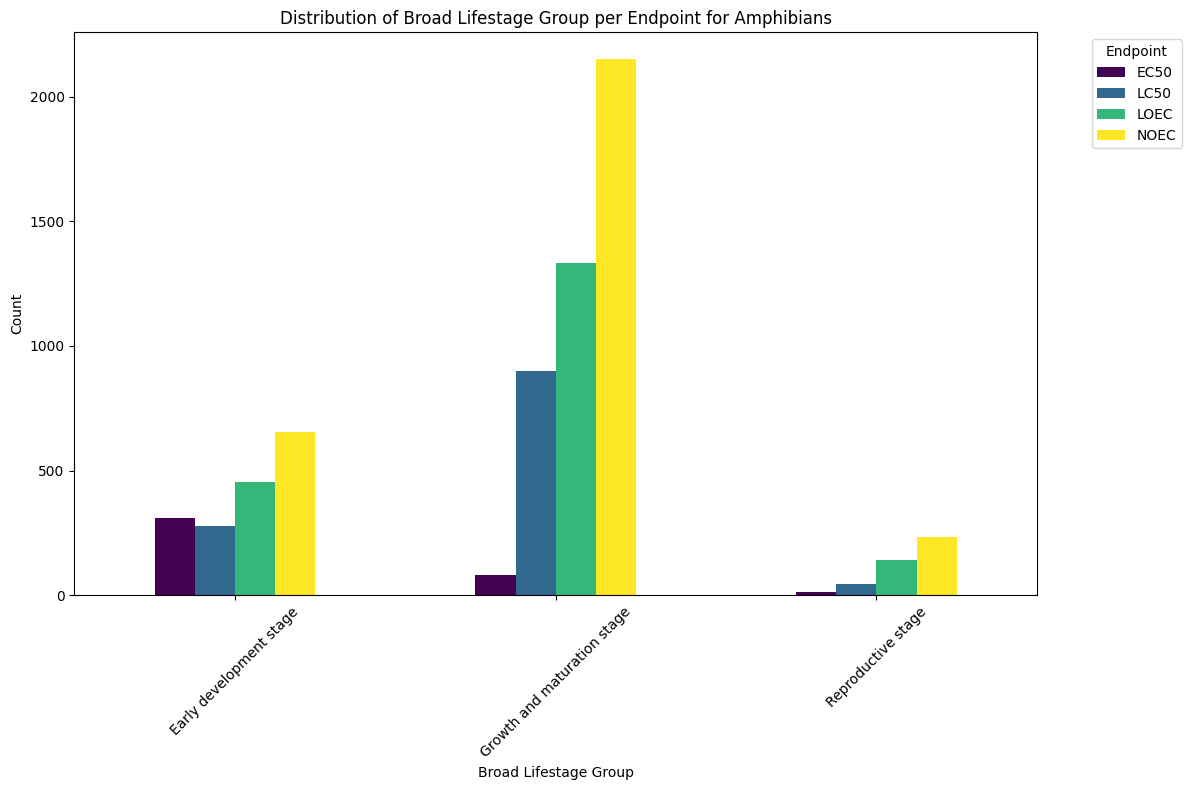

Data Distribution for Amphibians:
Endpoint                     EC50  LC50  LOEC  NOEC
Broad Lifestage Group                              
Early development stage       310   280   453   656
Growth and maturation stage    80   901  1334  2150
Reproductive stage             13    44   141   234 



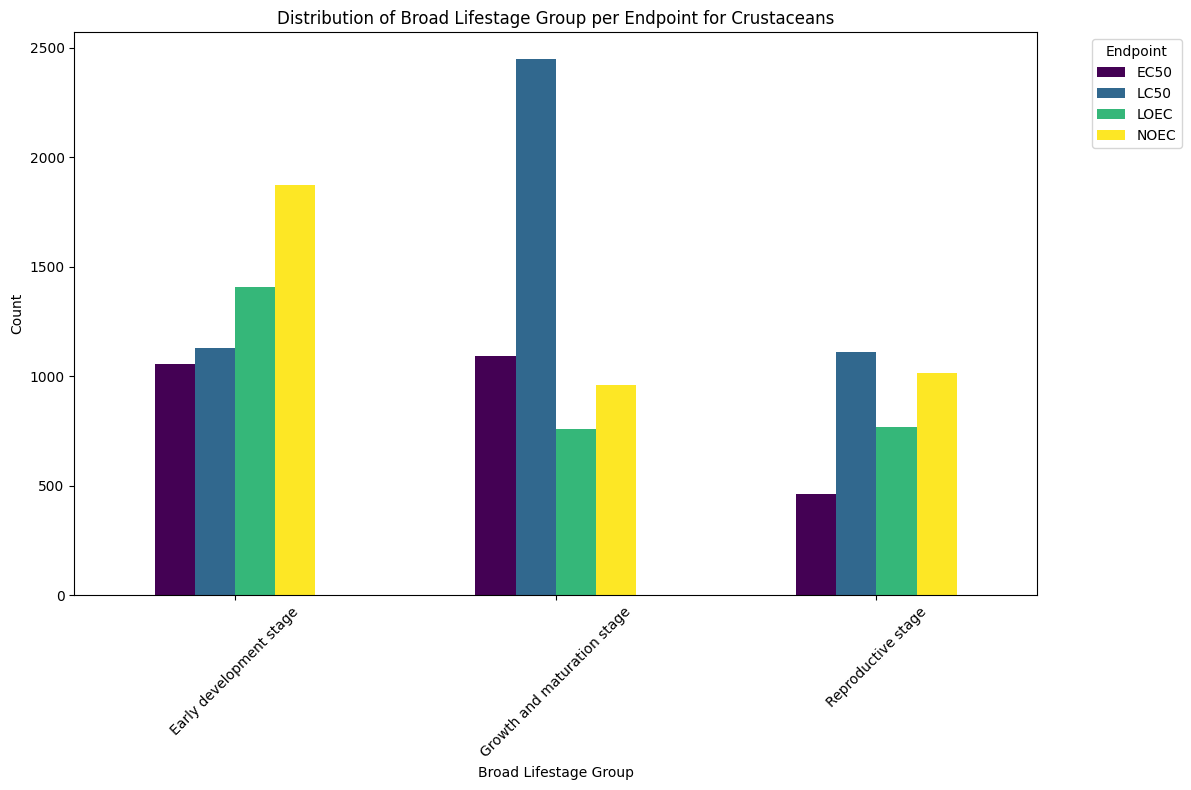

Data Distribution for Crustaceans:
Endpoint                     EC50  LC50  LOEC  NOEC
Broad Lifestage Group                              
Early development stage      1055  1129  1409  1874
Growth and maturation stage  1090  2447   757   962
Reproductive stage            462  1109   767  1014 



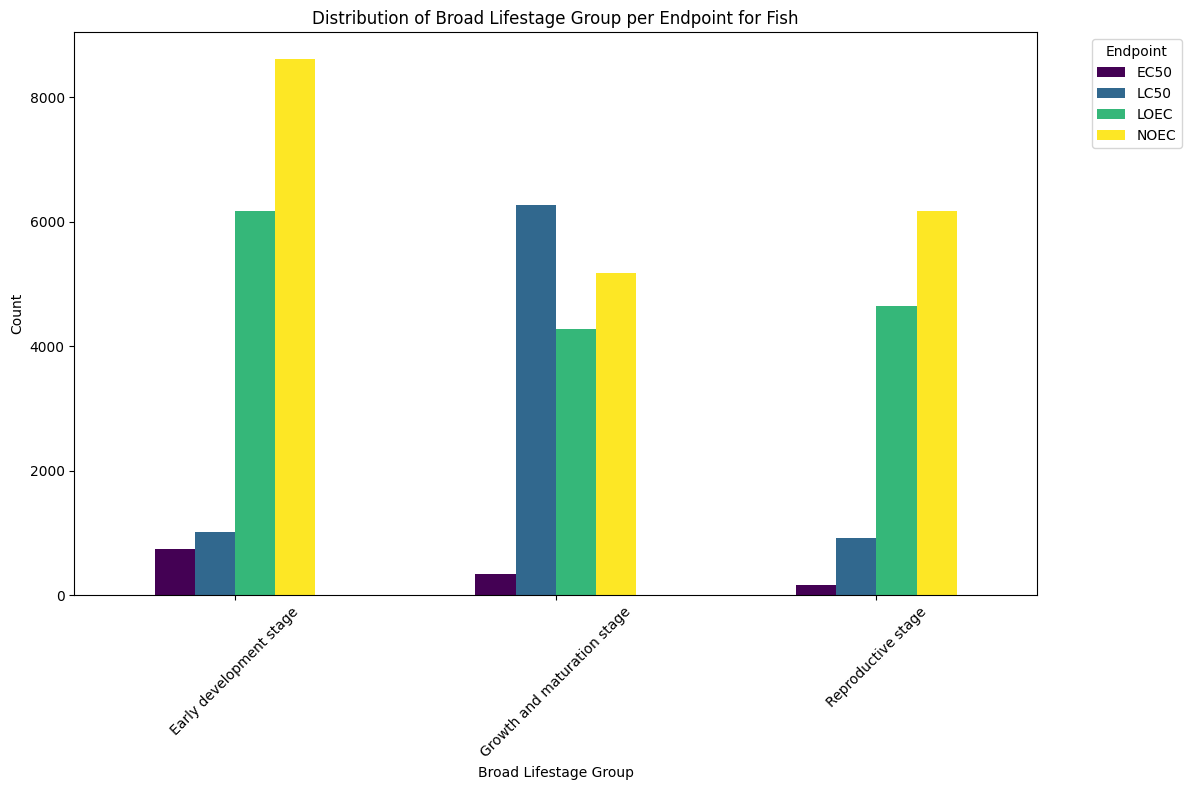

Data Distribution for Fish:
Endpoint                     EC50  LC50  LOEC  NOEC
Broad Lifestage Group                              
Early development stage       742  1011  6178  8613
Growth and maturation stage   347  6263  4273  5176
Reproductive stage            174   913  4644  6171 



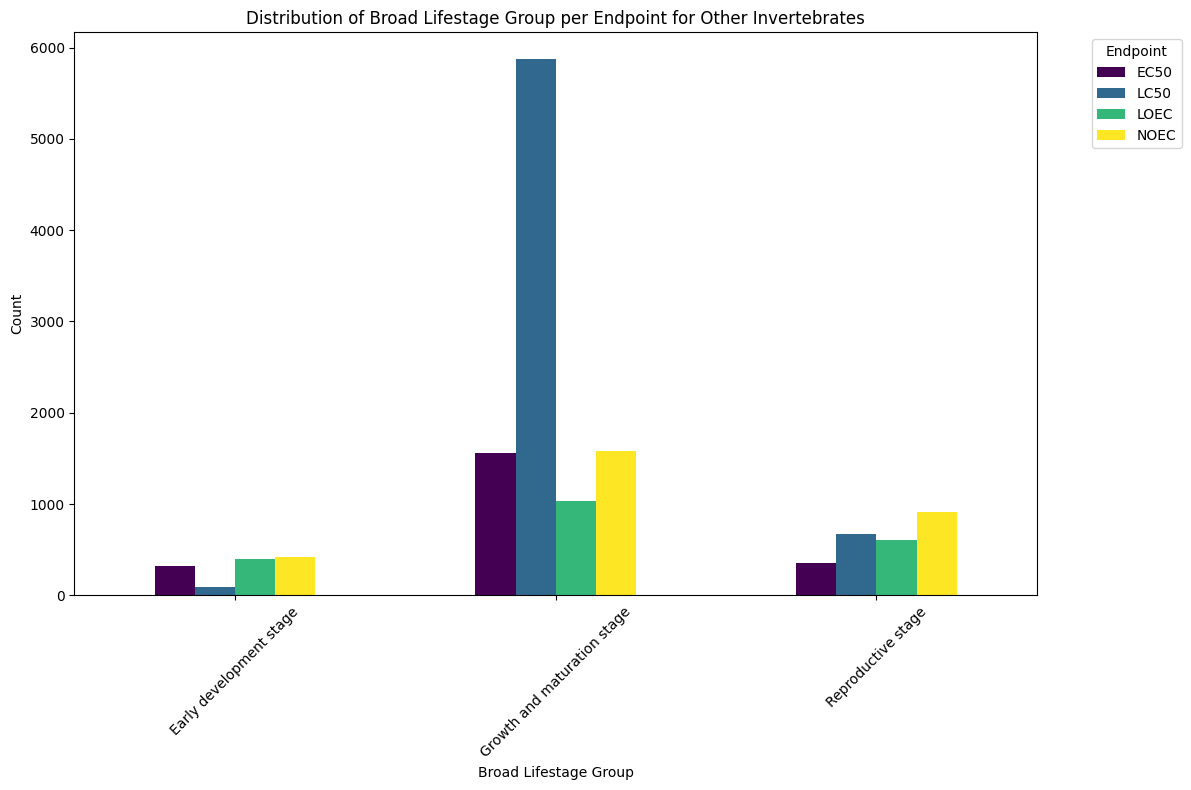

Data Distribution for Other Invertebrates:
Endpoint                     EC50  LC50  LOEC  NOEC
Broad Lifestage Group                              
Early development stage       317    90   401   416
Growth and maturation stage  1561  5874  1037  1584
Reproductive stage            355   671   606   917 



In [9]:
import matplotlib.pyplot as plt

# Get unique species from the 'Species Group' column
species_groups = curated_df['Species Group'].unique()

# Create an empty dictionary to store DataFrame for each species
species_pivot_tables = {}

for species in species_groups:
    # Filter DataFrame for the current species
    df_species = curated_df[curated_df['Species Group'] == species]

    # Group by 'Endpoint' and 'Broad Lifestage Group' and count the occurrences
    endpoint_lifestage_counts = df_species.groupby(['Endpoint', 'Broad Lifestage Group']).size()

    # Reset the index to turn the results into a DataFrame
    endpoint_lifestage_counts_df = endpoint_lifestage_counts.reset_index(name='Count')

    # Pivot the DataFrame to get 'Broad Lifestage Group' as rows, 'Endpoint' as columns, and 'Count' as cell values
    pivoted_df = endpoint_lifestage_counts_df.pivot(index='Broad Lifestage Group', columns='Endpoint', values='Count').fillna(0)

    if len(pivoted_df) > 0:
        # Store the pivoted DataFrame in the dictionary using the species name as the key
        species_pivot_tables[species] = pivoted_df

        # Plotting the data for the current species
        pivoted_df.plot(kind='bar', stacked=False, figsize=(12, 8), colormap='viridis')

        # Customizing the plot
        plt.title(f'Distribution of Broad Lifestage Group per Endpoint for {species}')
        plt.xlabel('Broad Lifestage Group')
        plt.ylabel('Count')
        plt.xticks(rotation=45)  # Rotate labels to improve readability
        plt.legend(title='Endpoint', bbox_to_anchor=(1.05, 1), loc='upper left')

        # Show and save the plot
        plt.tight_layout()
        plt.savefig(f'Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/Figures/LifeStageData_curated_distribution_{species}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Optionally print the pivoted DataFrame
        print(f"Data Distribution for {species}:")
        print(pivoted_df, "\n")
        pivoted_df.to_csv(f'Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/Stats/LifeStageData_curated_distribution_{species}.csv')

# Old Implementations

In [ ]:
import requests
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import SDWriter
import logging
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class ChemicalCuration:
    """
    A class to perform chemical data curation, including the removal of inorganics, organometallics, counterions,
    structure normalization, handling tautomers and isomers, and final validation.
    """

    def __init__(self, df):
        """
        Initialize the ChemicalCuration class with a DataFrame.

        Args:
            df (pandas.DataFrame): DataFrame containing chemical data with at least an 'Standardized_InChI' column.
        """
        self.df = df
        self.cleaned_data = None
        self.inchi_smiles_map = {}
        self.df['Curation_Status'] = ""  # Add a column for the curation status
        logging.info("ChemicalCuration initialized with DataFrame of shape %s", df.shape)

    def inchi_to_smiles(self, inchi):
        """
        Convert an InChI string to a SMILES string using RDKit.

        Args:
            inchi (str): The InChI string to convert.

        Returns:
            str: The corresponding SMILES string, or None if conversion fails.
        """
        try:
            mol = Chem.MolFromInchi(inchi)
            if mol:
                smiles = Chem.MolToSmiles(mol)
                logging.info("Converted InChI to SMILES: %s", smiles)
                return smiles
            else:
                logging.warning("RDKit could not convert InChI to a molecule object.")
        except Exception as e:
            logging.error("Failed to convert InChI to SMILES: %s", str(e))
        return None

    def is_organic(self, smiles):
        """
        Determine if a molecule is organic.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is organic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
            metals = {'Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                      'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs',
                      'Ba', 'La', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi'}
            if elements & metals or 'C' not in elements or len(elements) <= 1:
                return False
            return True
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles}: {e}")
            return False

    def is_counterion(self, smiles):
        """
        Determine if a molecule is a counterion.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a counterion, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            return Descriptors.MolWt(mol) < 100
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for counterion check: {e}")
            return False

    def is_biologic(self, smiles):
        """
        Determine if a molecule is a biologic.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a biologic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            peptide_bond_count = smiles.count('C(=O)N')
            return peptide_bond_count > 5
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for biologic check: {e}")
            return False

    def is_mixture(self, smiles):
        """
        Determine if a SMILES string represents a mixture.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the SMILES string represents a mixture, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            return '.' in smiles
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for mixture check: {e}")
            return False

    def process_inchi(self, inchi):
        """
        Process a single InChI to generate a SMILES and determine its validity.
        """
        smiles = self.inchi_to_smiles(inchi)
        if smiles:
            status = "SMILES conversion successful"
            if self.is_organic(smiles) and not self.is_counterion(smiles) and not self.is_biologic(smiles) and not self.is_mixture(smiles):
                status += ", Passed initial filtering"
                return inchi, status, smiles
            else:
                status += ", Failed initial filtering"
                return inchi, status, None
        else:
            return inchi, "SMILES conversion failed", None

    def remove_inorganics_and_mixtures(self):
        """
        Remove inorganic compounds, organometallics, counterions, biologics, and mixtures from the DataFrame.
        """
        unique_inchis = self.df['Standardized_InChI'].unique()

        with ThreadPoolExecutor(max_workers=3) as executor:
            futures = {executor.submit(self.process_inchi, inchi): inchi for inchi in unique_inchis}
            for future in as_completed(futures):
                inchi, status, smiles = future.result()
                self.df.loc[self.df['Standardized_InChI'] == inchi, 'Curation_Status'] = status
                if smiles:
                    self.inchi_smiles_map[inchi] = smiles

        self.df['Cleaned_SMILES'] = self.df['Standardized_InChI'].map(self.inchi_smiles_map)
        self.cleaned_data = self.df.dropna(subset=['Cleaned_SMILES'])

        if self.cleaned_data.empty:
            logging.error("No valid compounds after removing inorganics, organometallics, counterions, biologics, and mixtures.")
        else:
            logging.info(f"Cleaned data shape: {self.cleaned_data.shape}")

    def clean_structure(self, row):
        """
        Clean the structure for a single molecule and update its curation status.

        Args:
            row (pd.Series): A row from the DataFrame containing the SMILES string and curation status.

        Returns:
            str: Cleaned SMILES string, or None if cleaning fails.
        """
        smiles = row['Cleaned_SMILES']
        status = row['Curation_Status']

        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                status += ", Failed: Invalid SMILES"
                return None, status

            mol = Chem.AddHs(mol)

            try:
                Chem.SanitizeMol(mol)
            except Chem.MolSanitizeException:
                status += ", Valence violation corrected"
                Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_PROPERTIES)

            try:
                AllChem.UFFOptimizeMolecule(mol)
                status += ", Optimization successful"
            except Exception as e:
                status += ", Optimization failed"
                logging.warning(f"Optimization failed for SMILES: {smiles}. Reason: {e}")

            try:
                Chem.Kekulize(mol, clearAromaticFlags=True)
                Chem.SetAromaticity(mol)
                status += ", Aromatization successful"
            except Exception as e:
                status += ", Aromatization failed"
                logging.warning(f"Ring aromatization failed for SMILES: {smiles}. Reason: {e}")

            try:
                normalizer = rdMolStandardize.Normalizer()
                mol = normalizer.normalize(mol)
                status += ", Normalization successful"
            except Exception as e:
                status += ", Normalization failed"
                logging.error(f"Normalization failed for SMILES {smiles}. Reason: {e}")
                return None, status

            cleaned_smiles = Chem.MolToSmiles(mol)
            status += ", Tautomer rules applied successfully"
            return cleaned_smiles, status

        except Exception as e:
            logging.error(f"Failed to clean structure for SMILES {smiles}. Reason: {e}")
            status += ", Structural cleaning failed"
            return None, status

    def structural_cleaning(self):
        """
        Perform comprehensive structural cleaning on the chemical dataset in parallel.
        """
        def apply_tautomer_rules(mol):
            try:
                smirks_rules = [
                    ('[CX3]=[OX1]([#1])>>[CX3][OX2H]', 'Keto-enol'),
                    ('[CX3][OX2H]>>[CX3]=[OX1]([#1])', 'Enol-keto'),
                    ('[CX4H2][CX3]=[CX3H]>>[CX4H]=[CX3H][CX4H2]', 'Alkene Tautomer'),
                    ('[NX3][CX3]=[NX3]>>[NX3]=[CX3][NX3]', 'Imine-Amine'),
                    ('[NX3]=[CX3][OX2H]>>[NX3][CX3]=[OX1]', 'Imine-Oxime'),
                    ('[CX3](=[OX1])-[NX3][#1]>>[CX3](=[OX1])[NX2]=[NX2]', 'Amide-Imidic acid'),
                    ('[CX3](=[OX1])[NX2]=[NX2]>>[CX3](=[OX1])-[NX3][#1]', 'Imidic acid-Amide'),
                    ('[CX3](=[OX1])[NX3]=[NX3]>>[CX3](=[OX1])[NX2]=[NX3][#1]', 'Amidine-Imidamide'),
                    ('[NX2]=[NX3][#1]>>[NX3]=[NX3]', 'Imidamide-Amidine'),
                    ('[NX2]=[NX3][CX3](=[OX1])[OX2H]>>[NX3]=[NX3][CX3]=[OX1]', 'Guanidine-Guanidine'),
                    ('[NX2]=[NX3][CX3]=[OX1]>>[NX3]=[NX3][CX3](=[OX1])[OX2H]', 'Guanidine-Guanidine reverse'),
                    ('[CX3](=[OX1])[OX2H]>>[CX3](=[OX1])[OX1]', 'Carboxyl-Carboxylate'),
                    ('[CX3](=[OX1])[OX1]>>[CX3](=[OX1])[OX2H]', 'Carboxylate-Carboxyl'),
                    ('[OX1]=[CX3][CX3]=[CX3]>>[OX2H]-[CX3]=[CX3]', 'Beta-Diketone Enolization'),
                    ('[OX2H]-[CX3]=[CX3]>>[OX1]=[CX3][CX3]=[CX3]', 'Beta-Diketone Enolization reverse'),
                    ('[CX3](=[NX2][#1])[NX3][CX3](=[NX3])>>[CX3]=[NX3][CX3](=[NX3])[#1]', 'Amidoxime-Amidrazone'),
                    ('[CX3]=[NX3][CX3](=[NX3])[#1]>>[CX3](=[NX2][#1])[NX3][CX3](=[NX3])', 'Amidrazone-Amidoxime'),
                    ('[CX3](=[NX2])-[OX1]>>[CX3]=[NX3][OX2H]', 'Oxime-Nitrone'),
                    ('[CX3]=[NX3][OX2H]>>[CX3](=[NX2])-[OX1]', 'Nitrone-Oxime'),
                    ('[NX3]=[CX3][NX3]=[NX3]>>[NX3][CX3](=[NX2])[NX3]=[NX3]', 'Amidine-Amidrazone'),
                    ('[NX3][CX3](=[NX2])[NX3]=[NX3]>>[NX3]=[CX3][NX3]=[NX3]', 'Amidrazone-Amidine')
                ]
                for smirks, name in smirks_rules:
                    rxn = AllChem.ReactionFromSmarts(smirks)
                    products = rxn.RunReactants((mol,))
                    if products:
                        mol = products[0][0]
                        Chem.SanitizeMol(mol)  # Ensure implicit valence is recalculated
                return mol
            except Exception as e:
                logging.error(f"Failed to apply tautomer rules: {e}")
            return mol

        def clean_structure(row):
            """
            Clean the structure for a single molecule and update its curation status.

            Args:
                row (pd.Series): A row from the DataFrame containing the SMILES string and curation status.

            Returns:
                str: Cleaned SMILES string, or None if cleaning fails.
            """
            smiles = row['Cleaned_SMILES']
            status = row['Curation_Status']

            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    status += ", Failed: Invalid SMILES"
                    return None, status

                # Add explicit hydrogens
                mol = Chem.AddHs(mol)

                # Sanitize the molecule to check for valence and structural issues
                try:
                    Chem.SanitizeMol(mol)
                except Chem.MolSanitizeException:
                    status += ", Valence violation corrected"
                    Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_PROPERTIES)

                # Attempt MMFF94 optimization first
                try:
                    mmff_result = AllChem.MMFFOptimizeMolecule(mol)
                    if mmff_result == 0:  # 0 indicates success
                        status += ", MMFF94 optimization successful"
                    else:
                        status += ", MMFF94 optimization failed"
                except Exception as e:
                    logging.warning(f"MMFF94 optimization failed for SMILES: {smiles}. Reason: {e}")
                    status += ", MMFF94 optimization failed"

                    # Fallback to UFF optimization if MMFF94 fails
                    try:
                        uff_result = AllChem.UFFOptimizeMolecule(mol)
                        if uff_result == 0:  # 0 indicates success
                            status += ", UFF optimization successful"
                        else:
                            status += ", UFF optimization failed"
                    except Exception as e:
                        logging.error(f"UFF optimization failed for SMILES {smiles}. Reason: {e}")
                        status += ", UFF optimization failed"

                # Ring aromatization and aromaticity setting
                try:
                    Chem.Kekulize(mol, clearAromaticFlags=True)
                    Chem.SetAromaticity(mol)
                    status += ", Aromatization successful"
                except Exception as e:
                    logging.warning(f"Ring aromatization failed for SMILES: {smiles}. Reason: {e}")
                    status += ", Aromatization failed"

                # Apply normalization using RDKit MolStandardize
                try:
                    normalizer = rdMolStandardize.Normalizer()
                    mol = normalizer.normalize(mol)
                    status += ", Normalization successful"
                except Exception as e:
                    logging.error(f"Normalization failed for SMILES {smiles}. Reason: {e}")
                    status += ", Normalization failed"
                    return None, status

                # Apply tautomer rules if applicable
                mol = apply_tautomer_rules(mol)
                cleaned_smiles = Chem.MolToSmiles(mol)
                status += ", Tautomer rules applied successfully"
                return cleaned_smiles, status

            except Exception as e:
                logging.error(f"Failed to clean structure for SMILES {smiles}. Reason: {e}")
                status += ", Structural cleaning failed"
                return None, status

        with ThreadPoolExecutor(max_workers=3) as executor:
            futures = {executor.submit(self.clean_structure, row): idx for idx, row in self.cleaned_data.iterrows()}
            results = {future: idx for future, idx in futures.items()}

            for future in as_completed(results):
                idx = results[future]
                cleaned_smiles, status = future.result()
                self.cleaned_data.at[idx, 'Cleaned_SMILES'] = cleaned_smiles
                self.cleaned_data.at[idx, 'Curation_Status'] = status

        self.cleaned_data.dropna(subset=['Cleaned_SMILES'], inplace=True)
        logging.info("Structural cleaning completed. Cleaned data shape: %s", self.cleaned_data.shape)

    def verify_stereochemistry(self):
        """
        Verify the stereochemistry of bioactive chemicals in the dataset in parallel.
        """
        def get_stereocenters(mol):
            return Chem.FindMolChiralCenters(mol, includeUnassigned=True)

        def query_pubchem(smiles):
            url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/IsomericSMILES/JSON'
            try:
                response = requests.get(url)
                response.raise_for_status()
                data = response.json()
                return data['PropertyTable']['Properties'][0]['IsomericSMILES']
            except Exception as e:
                logging.error(f"Failed to query PubChem for SMILES {smiles}. Reason: {e}")
                return None

        def manual_curation_needed(stereo_centers, pubchem_smiles):
            if pubchem_smiles:
                pubchem_mol = Chem.MolFromSmiles(pubchem_smiles)
                pubchem_stereocenters = get_stereocenters(pubchem_mol)
                if stereo_centers != pubchem_stereocenters:
                    return True
            return False

        with ThreadPoolExecutor(max_workers=3) as executor:
            futures = {}
            for idx, row in self.cleaned_data.iterrows():
                smiles = row['Cleaned_SMILES']
                mol = Chem.MolFromSmiles(smiles)
                if not mol:
                    continue

                stereo_centers = get_stereocenters(mol)
                if stereo_centers:
                    futures[executor.submit(query_pubchem, smiles)] = (idx, stereo_centers)

            for future in as_completed(futures):
                idx, stereo_centers = futures[future]
                pubchem_smiles = future.result()
                status = self.cleaned_data.at[idx, 'Curation_Status']

                if manual_curation_needed(stereo_centers, pubchem_smiles):
                    status += ", Stereochemistry verification required"
                else:
                    status += ", Stereochemistry verified"

                self.cleaned_data.at[idx, 'Curation_Status'] = status

        logging.info("Stereochemistry verification completed for all entries.")

    def curate_data(self):
        logging.info("Starting data curation process.")

        self.remove_inorganics_and_mixtures()  # Parallelized
        self.structural_cleaning()             # Parallelized
        self.verify_stereochemistry()          # Parallelized

        logging.info("Data curation process completed with cleaned data shape: %s", self.cleaned_data.shape)
        return self.cleaned_data

    def generate_sdf(self, output_file):
        logging.info("Generating SDF file at %s", output_file)
        writer = SDWriter(output_file)
        for _, row in self.cleaned_data.iterrows():
            mol = Chem.MolFromSmiles(row['Cleaned_SMILES'])
            if mol is not None:
                mol.SetProp("InChI", row["Standardized_InChI"])
                writer.write(mol)
        writer.close()
        logging.info("SDF file generation complete.")

if __name__ == "__main__":
    df_with_inchi = pd.read_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIRetrieved.csv')

    curator = ChemicalCuration(df_with_inchi)
    curated_df = curator.curate_data()

    if not curated_df.empty:
        curated_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.csv', index=False)
        curator.generate_sdf('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.sdf')
    else:
        logging.error("Curation process resulted in no valid data. No output files were generated.")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import requests
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import SDWriter
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class ChemicalCuration:
    """
    A class to perform chemical data curation, including the removal of inorganics, organometallics, counterions,
    structure normalization, handling tautomers and isomers, and final validation.
    """

    def __init__(self, df):
        """
        Initialize the ChemicalCuration class with a DataFrame.

        Args:
            df (pandas.DataFrame): DataFrame containing chemical data with at least a 'Standardized_InChI' column.
        """
        self.df = df
        self.cleaned_data = None
        self.inchi_smiles_map = {}
        self.df['Curation_Status'] = ""  # Add a column for the curation status
        logging.info("ChemicalCuration initialized with DataFrame of shape %s", df.shape)

    def inchi_to_smiles(self, inchi):
        """
        Convert an InChI string to a SMILES string using RDKit.

        Args:
            inchi (str): The InChI string to convert.

        Returns:
            str: The corresponding SMILES string, or None if conversion fails.
        """
        try:
            mol = Chem.MolFromInchi(inchi)
            if mol:
                smiles = Chem.MolToSmiles(mol)
                logging.info("Converted InChI to SMILES: %s", smiles)
                return smiles
            else:
                logging.warning("RDKit could not convert InChI to a molecule object.")
        except Exception as e:
            logging.error("Failed to convert InChI to SMILES: %s", str(e))
        return None

    def is_organic(self, smiles):
        """
        Determine if a molecule is organic.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is organic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
            metals = {'Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                      'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs',
                      'Ba', 'La', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi'}
            if elements & metals or 'C' not in elements or len(elements) <= 1:
                return False
            return True
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles}: {e}")
            return False

    def is_counterion(self, smiles):
        """
        Determine if a molecule is a counterion.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a counterion, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            return Descriptors.MolWt(mol) < 100
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for counterion check: {e}")
            return False

    def is_biologic(self, smiles):
        """
        Determine if a molecule is a biologic.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a biologic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            peptide_bond_count = smiles.count('C(=O)N')
            return peptide_bond_count > 5
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for biologic check: {e}")
            return False

    def is_mixture(self, smiles):
        """
        Determine if a SMILES string represents a mixture.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the SMILES string represents a mixture, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            return '.' in smiles
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for mixture check: {e}")
            return False

    def remove_inorganics_and_mixtures(self):
        """
        Remove inorganic compounds, organometallics, counterions, biologics, and mixtures from the DataFrame.
        """
        unique_inchis = self.df['Standardized_InChI'].unique()

        for inchi in unique_inchis:
            smiles = self.inchi_to_smiles(inchi)
            if smiles:
                status = "SMILES conversion successful"
                if self.is_organic(smiles) and not self.is_counterion(smiles) and not self.is_biologic(smiles) and not self.is_mixture(smiles):
                    self.inchi_smiles_map[inchi] = smiles
                    status += ", Passed initial filtering"
                else:
                    status += ", Failed initial filtering"
            else:
                status = "SMILES conversion failed"
            self.df.loc[self.df['Standardized_InChI'] == inchi, 'Curation_Status'] = status

        self.df['Cleaned_SMILES'] = self.df['Standardized_InChI'].map(self.inchi_smiles_map)
        self.cleaned_data = self.df.dropna(subset=['Cleaned_SMILES'])

        if self.cleaned_data.empty:
            logging.error("No valid compounds after removing inorganics, organometallics, counterions, biologics, and mixtures.")
        else:
            logging.info(f"Cleaned data shape: {self.cleaned_data.shape}")

    def structural_cleaning(self):
        """
        Perform comprehensive structural cleaning on the chemical dataset, including:
        - Detection and correction of valence violations and extreme bond lengths/angles.
        - Ring aromatization.
        - Normalization of specific chemotypes.
        - Standardization of tautomeric forms using custom SMIRKS rules.
        """

        def apply_tautomer_rules(mol):
            try:
                smirks_rules = [
                    ('[CX3]=[OX1]([#1])>>[CX3][OX2H]', 'Keto-enol'),
                    ('[CX3][OX2H]>>[CX3]=[OX1]([#1])', 'Enol-keto'),
                    ('[CX4H2][CX3]=[CX3H]>>[CX4H]=[CX3H][CX4H2]', 'Alkene Tautomer'),
                    ('[NX3][CX3]=[NX3]>>[NX3]=[CX3][NX3]', 'Imine-Amine'),
                    ('[NX3]=[CX3][OX2H]>>[NX3][CX3]=[OX1]', 'Imine-Oxime'),
                    ('[CX3](=[OX1])-[NX3][#1]>>[CX3](=[OX1])[NX2]=[NX2]', 'Amide-Imidic acid'),
                    ('[CX3](=[OX1])[NX2]=[NX2]>>[CX3](=[OX1])-[NX3][#1]', 'Imidic acid-Amide'),
                    ('[CX3](=[OX1])[NX3]=[NX3]>>[CX3](=[OX1])[NX2]=[NX3][#1]', 'Amidine-Imidamide'),
                    ('[NX2]=[NX3][#1]>>[NX3]=[NX3]', 'Imidamide-Amidine'),
                    ('[NX2]=[NX3][CX3](=[OX1])[OX2H]>>[NX3]=[NX3][CX3]=[OX1]', 'Guanidine-Guanidine'),
                    ('[NX2]=[NX3][CX3]=[OX1]>>[NX3]=[NX3][CX3](=[OX1])[OX2H]', 'Guanidine-Guanidine reverse'),
                    ('[CX3](=[OX1])[OX2H]>>[CX3](=[OX1])[OX1]', 'Carboxyl-Carboxylate'),
                    ('[CX3](=[OX1])[OX1]>>[CX3](=[OX1])[OX2H]', 'Carboxylate-Carboxyl'),
                    ('[OX1]=[CX3][CX3]=[CX3]>>[OX2H]-[CX3]=[CX3]', 'Beta-Diketone Enolization'),
                    ('[OX2H]-[CX3]=[CX3]>>[OX1]=[CX3][CX3]=[CX3]', 'Beta-Diketone Enolization reverse'),
                    ('[CX3](=[NX2][#1])[NX3][CX3](=[NX3])>>[CX3]=[NX3][CX3](=[NX3])[#1]', 'Amidoxime-Amidrazone'),
                    ('[CX3]=[NX3][CX3](=[NX3])[#1]>>[CX3](=[NX2][#1])[NX3][CX3](=[NX3])', 'Amidrazone-Amidoxime'),
                    ('[CX3](=[NX2])-[OX1]>>[CX3]=[NX3][OX2H]', 'Oxime-Nitrone'),
                    ('[CX3]=[NX3][OX2H]>>[CX3](=[NX2])-[OX1]', 'Nitrone-Oxime'),
                    ('[NX3]=[CX3][NX3]=[NX3]>>[NX3][CX3](=[NX2])[NX3]=[NX3]', 'Amidine-Amidrazone'),
                    ('[NX3][CX3](=[NX2])[NX3]=[NX3]>>[NX3]=[CX3][NX3]=[NX3]', 'Amidrazone-Amidine')
                ]
                for smirks, name in smirks_rules:
                    rxn = AllChem.ReactionFromSmarts(smirks)
                    products = rxn.RunReactants((mol,))
                    if products:
                        mol = products[0][0]
                        Chem.SanitizeMol(mol)  # Ensure implicit valence is recalculated
                return mol
            except Exception as e:
                logging.error(f"Failed to apply tautomer rules: {e}")
            return mol

        def clean_structure(row):
            """
            Clean the structure for a single molecule and update its curation status.

            Args:
                row (pd.Series): A row from the DataFrame containing the SMILES string and curation status.

            Returns:
                str: Cleaned SMILES string, or None if cleaning fails.
            """
            smiles = row['Cleaned_SMILES']
            status = row['Curation_Status']

            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    status += ", Failed: Invalid SMILES"
                    return None, status

                mol = Chem.AddHs(mol)

                try:
                    Chem.SanitizeMol(mol)
                except Chem.MolSanitizeException:
                    status += ", Valence violation corrected"
                    Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_PROPERTIES)

                try:
                    AllChem.UFFOptimizeMolecule(mol)
                    status += ", Optimization successful"
                except Exception as e:
                    status += ", Optimization failed"
                    logging.warning(f"Optimization failed for SMILES: {smiles}. Reason: {e}")

                try:
                    Chem.Kekulize(mol, clearAromaticFlags=True)
                    Chem.SetAromaticity(mol)
                    status += ", Aromatization successful"
                except Exception as e:
                    status += ", Aromatization failed"
                    logging.warning(f"Ring aromatization failed for SMILES: {smiles}. Reason: {e}")

                try:
                    normalizer = rdMolStandardize.Normalizer()
                    mol = normalizer.normalize(mol)
                    status += ", Normalization successful"
                except Exception as e:
                    status += ", Normalization failed"
                    logging.error(f"Normalization failed for SMILES {smiles}. Reason: {e}")
                    return None, status

                mol = apply_tautomer_rules(mol)
                cleaned_smiles = Chem.MolToSmiles(mol)
                status += ", Tautomer rules applied successfully"
                return cleaned_smiles, status

            except Exception as e:
                logging.error(f"Failed to clean structure for SMILES {smiles}. Reason: {e}")
                status += ", Structural cleaning failed"
                return None, status

        # Apply cleaning and update status
        self.cleaned_data[['Cleaned_SMILES', 'Curation_Status']] = self.cleaned_data.apply(clean_structure, axis=1, result_type='expand')

        # Remove rows where cleaning failed
        self.cleaned_data.dropna(subset=['Cleaned_SMILES'], inplace=True)
        self.cleaned_data.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated-Step2.csv', index=False)
        logging.info("Structural cleaning completed. Cleaned data shape: %s", self.cleaned_data.shape)

    def verify_stereochemistry(self):
        """
        Verify the stereochemistry of bioactive chemicals in the dataset.
        """
        def get_stereocenters(mol):
            return Chem.FindMolChiralCenters(mol, includeUnassigned=True)

        def query_pubchem(smiles):
            url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/IsomericSMILES/JSON'
            try:
                response = requests.get(url)
                response.raise_for_status()
                data = response.json()
                return data['PropertyTable']['Properties'][0]['IsomericSMILES']
            except Exception as e:
                logging.error(f"Failed to query PubChem for SMILES {smiles}. Reason: {e}")
                return None

        def manual_curation_needed(stereo_centers, pubchem_smiles):
            if pubchem_smiles:
                pubchem_mol = Chem.MolFromSmiles(pubchem_smiles)
                pubchem_stereocenters = get_stereocenters(pubchem_mol)
                if stereo_centers != pubchem_stereocenters:
                    return True
            return False

        for idx, row in self.cleaned_data.iterrows():
            smiles = row['Cleaned_SMILES']
            mol = Chem.MolFromSmiles(smiles)
            status = row['Curation_Status']

            if not mol:
                continue

            stereo_centers = get_stereocenters(mol)
            if stereo_centers:
                pubchem_smiles = query_pubchem(smiles)
                if manual_curation_needed(stereo_centers, pubchem_smiles):
                    status += ", Stereochemistry verification required"
                else:
                    status += ", Stereochemistry verified"

            self.cleaned_data.at[idx, 'Curation_Status'] = status

        logging.info("Stereochemistry verification completed for all entries.")

    def curate_data(self):
        logging.info("Starting data curation process.")
        self.remove_inorganics_and_mixtures()
        self.structural_cleaning()
        self.verify_stereochemistry()
        logging.info("Data curation process completed with cleaned data shape: %s", self.cleaned_data.shape)
        return self.cleaned_data

    def generate_sdf(self, output_file):
        logging.info("Generating SDF file at %s", output_file)
        writer = SDWriter(output_file)
        for _, row in self.cleaned_data.iterrows():
            mol = Chem.MolFromSmiles(row['Cleaned_SMILES'])
            if mol is not None:
                mol.SetProp("InChI", row["Standardized_InChI"])
                writer.write(mol)
        writer.close()
        logging.info("SDF file generation complete.")

if __name__ == "__main__":
    df_with_inchi = pd.read_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIRetrieved.csv')

    curator = ChemicalCuration(df_with_inchi)
    curated_df = curator.curate_data()

    if not curated_df.empty:
        curated_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.csv', index=False)
        curator.generate_sdf('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.sdf')
    else:
        logging.error("Curation process resulted in no valid data. No output files were generated.")

In [ ]:
import requests
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import SDWriter
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class ChemicalCuration:
    """
    A class to perform chemical data curation, including the removal of inorganics, organometallics, counterions,
    structure normalization, handling tautomers and isomers, and final validation.
    """

    def __init__(self, df):
        """
        Initialize the ChemicalCuration class with a DataFrame.

        Args:
            df (pandas.DataFrame): DataFrame containing chemical data with at least an 'Standardized_InChI' column.
        """
        self.df = df
        self.cleaned_data = None
        self.inchi_smiles_map = {}
        self.df['Curation_Status'] = ""  # Add a column for the curation status
        logging.info("ChemicalCuration initialized with DataFrame of shape %s", df.shape)

    def inchi_to_smiles(self, inchi):
        """
        Convert an InChI string to a SMILES string using RDKit.

        Args:
            inchi (str): The InChI string to convert.

        Returns:
            str: The corresponding SMILES string, or None if conversion fails.
        """
        try:
            mol = Chem.MolFromInchi(inchi)
            if mol:
                smiles = Chem.MolToSmiles(mol)
                logging.info("Converted InChI to SMILES: %s", smiles)
                return smiles
            else:
                logging.warning("RDKit could not convert InChI to a molecule object.")
        except Exception as e:
            logging.error("Failed to convert InChI to SMILES: %s", str(e))
        return None


    def is_organic(self, smiles):
        """
        Determine if a molecule is organic.

        An organic molecule must contain carbon and at least one other element. It must not contain metals or be too small to be a typical organic compound.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is organic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
            metals = {'Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                      'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs',
                      'Ba', 'La', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi'}
            if elements & metals or 'C' not in elements or len(elements) <= 1:
                return False
            return True
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles}: {e}")
            return False

    def is_counterion(self, smiles):
        """
        Determine if a molecule is a counterion.

        Counterions are typically small ions used to balance charges in salts. This function uses a molecular weight threshold to identify them.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a counterion, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            return Descriptors.MolWt(mol) < 100
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for counterion check: {e}")
            return False

    def is_biologic(self, smiles):
        """
        Determine if a molecule is a biologic.

        Biologics often contain multiple peptide bonds and are larger, more complex molecules. This function uses a simple heuristic to detect them.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a biologic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            peptide_bond_count = smiles.count('C(=O)N')
            return peptide_bond_count > 5
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for biologic check: {e}")
            return False

    def is_mixture(self, smiles):
        """
        Determine if a SMILES string represents a mixture.

        A mixture is defined as a SMILES string containing multiple components, usually separated by a '.' character.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the SMILES string represents a mixture, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            return '.' in smiles
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for mixture check: {e}")
            return False


    def remove_inorganics_and_mixtures(self):
        """
        Remove inorganic compounds, organometallics, counterions, biologics, and mixtures from the DataFrame.
        """
        unique_inchis = self.df['Standardized_InChI'].unique()

        for inchi in unique_inchis:
            smiles = self.inchi_to_smiles(inchi)
            if smiles:
                status = "SMILES conversion successful"
                if self.is_organic(smiles) and not self.is_counterion(smiles) and not self.is_biologic(smiles) and not self.is_mixture(smiles):
                    self.inchi_smiles_map[inchi] = smiles
                    status += ", Passed initial filtering"
                else:
                    status += ", Failed initial filtering"
            else:
                status = "SMILES conversion failed"
            self.df.loc[self.df['Standardized_InChI'] == inchi, 'Curation_Status'] = status

        self.df['Cleaned_SMILES'] = self.df['Standardized_InChI'].map(self.inchi_smiles_map)
        self.cleaned_data = self.df.dropna(subset=['Cleaned_SMILES'])

        if self.cleaned_data.empty:
            logging.error("No valid compounds after removing inorganics, organometallics, counterions, biologics, and mixtures.")
        else:
            logging.info(f"Cleaned data shape: {self.cleaned_data.shape}")

    def structural_cleaning(self):
        """
        Perform comprehensive structural cleaning on the chemical dataset, including:
        - Detection and correction of valence violations and extreme bond lengths/angles.
        - Ring aromatization.
        - Normalization of specific chemotypes.
        - Standardization of tautomeric forms using custom SMIRKS rules.
        """

        def apply_tautomer_rules(mol):
            try:
                smirks_rules = [
                    ('[CX3]=[OX1]([#1])>>[CX3][OX2H]', 'Keto-enol'),
                    ('[CX3][OX2H]>>[CX3]=[OX1]([#1])', 'Enol-keto'),
                    ('[CX4H2][CX3]=[CX3H]>>[CX4H]=[CX3H][CX4H2]', 'Alkene Tautomer'),
                    ('[NX3][CX3]=[NX3]>>[NX3]=[CX3][NX3]', 'Imine-Amine'),
                    ('[NX3]=[CX3][OX2H]>>[NX3][CX3]=[OX1]', 'Imine-Oxime'),
                    ('[CX3](=[OX1])-[NX3][#1]>>[CX3](=[OX1])[NX2]=[NX2]', 'Amide-Imidic acid'),
                    ('[CX3](=[OX1])[NX2]=[NX2]>>[CX3](=[OX1])-[NX3][#1]', 'Imidic acid-Amide'),
                    ('[CX3](=[OX1])[NX3]=[NX3]>>[CX3](=[OX1])[NX2]=[NX3][#1]', 'Amidine-Imidamide'),
                    ('[NX2]=[NX3][#1]>>[NX3]=[NX3]', 'Imidamide-Amidine'),
                    ('[NX2]=[NX3][CX3](=[OX1])[OX2H]>>[NX3]=[NX3][CX3]=[OX1]', 'Guanidine-Guanidine'),
                    ('[NX2]=[NX3][CX3]=[OX1]>>[NX3]=[NX3][CX3](=[OX1])[OX2H]', 'Guanidine-Guanidine reverse'),
                    ('[CX3](=[OX1])[OX2H]>>[CX3](=[OX1])[OX1]', 'Carboxyl-Carboxylate'),
                    ('[CX3](=[OX1])[OX1]>>[CX3](=[OX1])[OX2H]', 'Carboxylate-Carboxyl'),
                    ('[OX1]=[CX3][CX3]=[CX3]>>[OX2H]-[CX3]=[CX3]', 'Beta-Diketone Enolization'),
                    ('[OX2H]-[CX3]=[CX3]>>[OX1]=[CX3][CX3]=[CX3]', 'Beta-Diketone Enolization reverse'),
                    ('[CX3](=[NX2][#1])[NX3][CX3](=[NX3])>>[CX3]=[NX3][CX3](=[NX3])[#1]', 'Amidoxime-Amidrazone'),
                    ('[CX3]=[NX3][CX3](=[NX3])[#1]>>[CX3](=[NX2][#1])[NX3][CX3](=[NX3])', 'Amidrazone-Amidoxime'),
                    ('[CX3](=[NX2])-[OX1]>>[CX3]=[NX3][OX2H]', 'Oxime-Nitrone'),
                    ('[CX3]=[NX3][OX2H]>>[CX3](=[NX2])-[OX1]', 'Nitrone-Oxime'),
                    ('[NX3]=[CX3][NX3]=[NX3]>>[NX3][CX3](=[NX2])[NX3]=[NX3]', 'Amidine-Amidrazone'),
                    ('[NX3][CX3](=[NX2])[NX3]=[NX3]>>[NX3]=[CX3][NX3]=[NX3]', 'Amidrazone-Amidine')
                ]
                for smirks, name in smirks_rules:
                    rxn = AllChem.ReactionFromSmarts(smirks)
                    products = rxn.RunReactants((mol,))
                    if products:
                        mol = products[0][0]
                        Chem.SanitizeMol(mol)  # Ensure implicit valence is recalculated
                return mol

            except Exception as e:
                logging.error(f"Failed to apply tautomer rules: {e}")
            return mol

        def clean_structure(row):
            """
            Clean the structure for a single molecule and update its curation status.

            Args:
                row (pd.Series): A row from the DataFrame containing the SMILES string and curation status.

            Returns:
                str: Cleaned SMILES string, or None if cleaning fails.
            """
            smiles = row['Cleaned_SMILES']
            status = row['Curation_Status']

            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    status += ", Failed: Invalid SMILES"
                    return None, status

                mol = Chem.AddHs(mol)

                try:
                    Chem.SanitizeMol(mol)
                except Chem.MolSanitizeException:
                    status += ", Valence violation corrected"
                    Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_PROPERTIES)

                try:
                    AllChem.UFFOptimizeMolecule(mol)
                    status += ", Optimization successful"
                except Exception as e:
                    status += ", Optimization failed"
                    logging.warning(f"Optimization failed for SMILES: {smiles}. Reason: {e}")

                try:
                    Chem.Kekulize(mol, clearAromaticFlags=True)
                    Chem.SetAromaticity(mol)
                    status += ", Aromatization successful"
                except Exception as e:
                    status += ", Aromatization failed"
                    logging.warning(f"Ring aromatization failed for SMILES: {smiles}. Reason: {e}")

                try:
                    normalizer = rdMolStandardize.Normalizer()
                    mol = normalizer.normalize(mol)
                    status += ", Normalization successful"
                except Exception as e:
                    status += ", Normalization failed"
                    logging.error(f"Normalization failed for SMILES {smiles}. Reason: {e}")
                    return None, status

                mol = apply_tautomer_rules(mol)
                cleaned_smiles = Chem.MolToSmiles(mol)
                status += ", Tautomer rules applied successfully"
                return cleaned_smiles, status

            except Exception as e:
                logging.error(f"Failed to clean structure for SMILES {smiles}. Reason: {e}")
                status += ", Structural cleaning failed"
                return None, status

        # Apply cleaning and update status
        self.cleaned_data[['Cleaned_SMILES', 'Curation_Status']] = self.cleaned_data.apply(clean_structure, axis=1, result_type='expand')

        # Remove rows where cleaning failed
        self.cleaned_data.dropna(subset=['Cleaned_SMILES'], inplace=True)
        self.cleaned_data.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated-Step2.csv', index=False)
        logging.info("Structural cleaning completed. Cleaned data shape: %s", self.cleaned_data.shape)

    def verify_stereochemistry(self):
        """
        Verify the stereochemistry of bioactive chemicals in the dataset.
        """
        def get_stereocenters(mol):
            return Chem.FindMolChiralCenters(mol, includeUnassigned=True)

        def query_pubchem(smiles):
            url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/IsomericSMILES/JSON'
            try:
                response = requests.get(url)
                response.raise_for_status()
                data = response.json()
                return data['PropertyTable']['Properties'][0]['IsomericSMILES']
            except Exception as e:
                logging.error(f"Failed to query PubChem for SMILES {smiles}. Reason: {e}")
                return None

        def manual_curation_needed(stereo_centers, pubchem_smiles):
            if pubchem_smiles:
                pubchem_mol = Chem.MolFromSmiles(pubchem_smiles)
                pubchem_stereocenters = get_stereocenters(pubchem_mol)
                if stereo_centers != pubchem_stereocenters:
                    return True
            return False

        for idx, row in self.cleaned_data.iterrows():
            smiles = row['Cleaned_SMILES']
            mol = Chem.MolFromSmiles(smiles)
            status = row['Curation_Status']

            if not mol:
                continue

            stereo_centers = get_stereocenters(mol)
            if stereo_centers:
                pubchem_smiles = query_pubchem(smiles)
                if manual_curation_needed(stereo_centers, pubchem_smiles):
                    status += ", Stereochemistry verification required"
                else:
                    status += ", Stereochemistry verified"

            self.cleaned_data.at[idx, 'Curation_Status'] = status

        logging.info("Stereochemistry verification completed for all entries.")

    def curate_data(self):
        logging.info("Starting data curation process.")

        self.remove_inorganics_and_mixtures()  # Use the correct method for initial processing
        self.structural_cleaning()
        self.verify_stereochemistry()

        logging.info("Data curation process completed with cleaned data shape: %s", self.cleaned_data.shape)
        return self.cleaned_data

    def generate_sdf(self, output_file):
        logging.info("Generating SDF file at %s", output_file)
        writer = SDWriter(output_file)
        for _, row in self.cleaned_data.iterrows():
            mol = Chem.MolFromSmiles(row['Cleaned_SMILES'])
            if mol is not None:
                mol.SetProp("InChIKey", row["InChIKey"])
                writer.write(mol)
        writer.close()
        logging.info("SDF file generation complete.")

if __name__ == "__main__":
    df_with_inchi = pd.read_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIRetrieved.csv')

    curator = ChemicalCuration(df_with_inchi)
    curated_df = curator.curate_data()

    if not curated_df.empty:
        curated_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.csv', index=False)
        curator.generate_sdf('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.sdf')
    else:
        logging.error("Curation process resulted in no valid data. No output files were generated.")

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import SDWriter
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class ChemicalCuration:
    """
    A class to perform chemical data curation, including the removal of inorganics, organometallics, counterions,
    structure normalization, handling tautomers and isomers, and final validation.
    """

    def __init__(self, df):
        """
        Initialize the ChemicalCuration class with a DataFrame.

        Args:
            df (pandas.DataFrame): DataFrame containing chemical data with at least an 'Standardized_InChI' column.
        """
        self.df = df
        self.cleaned_data = None
        self.inchi_smiles_map = {}
        logging.info("ChemicalCuration initialized with DataFrame of shape %s", df.shape)

    def inchi_to_smiles(self, inchi):
        """
        Convert an InChI string to a SMILES string using RDKit.

        Args:
            inchi (str): The InChI string to convert.

        Returns:
            str: The corresponding SMILES string, or None if conversion fails.
        """
        try:
            mol = Chem.MolFromInchi(inchi)
            if mol:
                smiles = Chem.MolToSmiles(mol)
                logging.info("Converted InChI to SMILES: %s", smiles)
                return smiles
            else:
                logging.warning("RDKit could not convert InChI to a molecule object.")
        except Exception as e:
            logging.error("Failed to convert InChI to SMILES: %s", str(e))
        return None

    def remove_inorganics_and_mixtures(self):
        """
        Remove inorganic compounds, organometallics, counterions, biologics, and mixtures from the DataFrame.
        Organic compounds must contain carbon and at least one other element, and should not contain metals, counterions, or multiple disconnected components.
        """
        unique_inchis = self.df['Standardized_InChI'].unique()
        inchi_smiles_map = {}

        # Convert each unique InChI to a SMILES string once
        for inchi in unique_inchis:
            smiles = self.inchi_to_smiles(inchi)
            if smiles and self.is_organic(smiles) and not self.is_counterion(smiles) and not self.is_biologic(smiles) and not self.is_mixture(smiles):
                inchi_smiles_map[inchi] = smiles

        # Map the valid SMILES back to the DataFrame entries
        self.df['Cleaned_SMILES'] = self.df['Standardized_InChI'].map(inchi_smiles_map)
        self.cleaned_data = self.df.dropna(subset=['Cleaned_SMILES'])

        if self.cleaned_data.empty:
            logging.error("No valid compounds after removing inorganics, organometallics, counterions, biologics, and mixtures.")
        else:
            logging.info(f"Cleaned data shape: {self.cleaned_data.shape}")

        self.cleaned_data.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated-Step1.csv', index=False)
        logging.info("Removed inorganics, organometallics, counterions, biologics, and mixtures. Cleaned data shape: %s", self.cleaned_data.shape)

    def process_unique_inchis(self):
        """
        Process only unique InChI strings to remove inorganics, organometallics, counterions, biologics, and mixtures.
        The resulting SMILES strings are stored in a dictionary to map back to the original DataFrame later.
        """
        unique_inchis = self.df['Standardized_InChI'].unique()
        logging.info("Processing %d unique InChIs.", len(unique_inchis))

        # Convert each unique InChI to a SMILES string once
        for inchi in unique_inchis:
            smiles = self.inchi_to_smiles(inchi)
            if smiles and self.is_organic(smiles) and not self.is_counterion(smiles) and not self.is_biologic(smiles) and not self.is_mixture(smiles):
                self.inchi_smiles_map[inchi] = smiles

        logging.info("Finished processing unique InChIs.")

    def is_organic(self, smiles):
        """
        Determine if a molecule is organic.

        An organic molecule must contain carbon and at least one other element. It must not contain metals or be too small to be a typical organic compound.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is organic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
            metals = {'Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                      'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs',
                      'Ba', 'La', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi'}
            if elements & metals or 'C' not in elements or len(elements) <= 1:
                return False
            return True
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles}: {e}")
            return False

    def is_counterion(self, smiles):
        """
        Determine if a molecule is a counterion.

        Counterions are typically small ions used to balance charges in salts. This function uses a molecular weight threshold to identify them.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a counterion, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            return Descriptors.MolWt(mol) < 100
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for counterion check: {e}")
            return False

    def is_biologic(self, smiles):
        """
        Determine if a molecule is a biologic.

        Biologics often contain multiple peptide bonds and are larger, more complex molecules. This function uses a simple heuristic to detect them.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a biologic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            peptide_bond_count = smiles.count('C(=O)N')
            return peptide_bond_count > 5
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for biologic check: {e}")
            return False

    def is_mixture(self, smiles):
        """
        Determine if a SMILES string represents a mixture.

        A mixture is defined as a SMILES string containing multiple components, usually separated by a '.' character.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the SMILES string represents a mixture, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            return '.' in smiles
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for mixture check: {e}")
            return False

    def structural_cleaning(self):
        """
        Perform comprehensive structural cleaning on the chemical dataset, including:
        - Detection and correction of valence violations and extreme bond lengths/angles.
        - Ring aromatization.
        - Normalization of specific chemotypes.
        - Standardization of tautomeric forms using custom SMIRKS rules.

        Returns:
            None: The function modifies the DataFrame in place, updating the `cleaned_data` with the cleaned structures.
        """

        def apply_tautomer_rules(mol):
            """
            Apply a set of custom tautomer rules using RDKit's reaction capabilities.

            Args:
                mol (rdkit.Chem.Mol): The RDKit molecule object.

            Returns:
                rdkit.Chem.Mol: The molecule with standardized tautomers.
            """
            try:
                smirks_rules = [
                    ('[CX3]=[OX1]([#1])>>[CX3][OX2H]', 'Keto-enol'),
                    ('[CX3][OX2H]>>[CX3]=[OX1]([#1])', 'Enol-keto'),
                    ('[CX4H2][CX3]=[CX3H]>>[CX4H]=[CX3H][CX4H2]', 'Alkene Tautomer'),
                    ('[NX3][CX3]=[NX3]>>[NX3]=[CX3][NX3]', 'Imine-Amine'),
                    ('[NX3]=[CX3][OX2H]>>[NX3][CX3]=[OX1]', 'Imine-Oxime'),
                    ('[CX3](=[OX1])-[NX3][#1]>>[CX3](=[OX1])[NX2]=[NX2]', 'Amide-Imidic acid'),
                    ('[CX3](=[OX1])[NX2]=[NX2]>>[CX3](=[OX1])-[NX3][#1]', 'Imidic acid-Amide'),
                    ('[CX3](=[OX1])[NX3]=[NX3]>>[CX3](=[OX1])[NX2]=[NX3][#1]', 'Amidine-Imidamide'),
                    ('[NX2]=[NX3][#1]>>[NX3]=[NX3]', 'Imidamide-Amidine'),
                    ('[NX2]=[NX3][CX3](=[OX1])[OX2H]>>[NX3]=[NX3][CX3]=[OX1]', 'Guanidine-Guanidine'),
                    ('[NX2]=[NX3][CX3]=[OX1]>>[NX3]=[NX3][CX3](=[OX1])[OX2H]', 'Guanidine-Guanidine reverse'),
                    ('[CX3](=[OX1])[OX2H]>>[CX3](=[OX1])[OX1]', 'Carboxyl-Carboxylate'),
                    ('[CX3](=[OX1])[OX1]>>[CX3](=[OX1])[OX2H]', 'Carboxylate-Carboxyl'),
                    ('[OX1]=[CX3][CX3]=[CX3]>>[OX2H]-[CX3]=[CX3]', 'Beta-Diketone Enolization'),
                    ('[OX2H]-[CX3]=[CX3]>>[OX1]=[CX3][CX3]=[CX3]', 'Beta-Diketone Enolization reverse'),
                    ('[CX3](=[NX2][#1])[NX3][CX3](=[NX3])>>[CX3]=[NX3][CX3](=[NX3])[#1]', 'Amidoxime-Amidrazone'),
                    ('[CX3]=[NX3][CX3](=[NX3])[#1]>>[CX3](=[NX2][#1])[NX3][CX3](=[NX3])', 'Amidrazone-Amidoxime'),
                    ('[CX3](=[NX2])-[OX1]>>[CX3]=[NX3][OX2H]', 'Oxime-Nitrone'),
                    ('[CX3]=[NX3][OX2H]>>[CX3](=[NX2])-[OX1]', 'Nitrone-Oxime'),
                    ('[NX3]=[CX3][NX3]=[NX3]>>[NX3][CX3](=[NX2])[NX3]=[NX3]', 'Amidine-Amidrazone'),
                    ('[NX3][CX3](=[NX2])[NX3]=[NX3]>>[NX3]=[CX3][NX3]=[NX3]', 'Amidrazone-Amidine')                ]

                for smirks, name in smirks_rules:
                    rxn = AllChem.ReactionFromSmarts(smirks)
                    products = rxn.RunReactants((mol,))
                    if products:
                        mol = products[0][0]
                        Chem.SanitizeMol(mol)  # Ensure implicit valence is recalculated
                return mol

            except Exception as e:
                logging.error(f"Failed to apply tautomer rules: {e}")
            return mol

        def clean_structure(smiles):
            """
            Apply structural cleaning to a single molecule.

            Args:
                smiles (str): SMILES string of the molecule.

            Returns:
                str: Cleaned SMILES string, or None if cleaning fails.
            """
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    return None

                mol = Chem.AddHs(mol)
                try:
                    Chem.SanitizeMol(mol)
                except Chem.MolSanitizeException:
                    logging.warning(f"Valence violation detected and corrected for SMILES: {smiles}")
                    Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_PROPERTIES)

                try:
                    AllChem.UFFOptimizeMolecule(mol)
                except Exception as e:
                    logging.warning(f"Optimization failed for SMILES: {smiles}. Reason: {e}")

                try:
                    Chem.Kekulize(mol, clearAromaticFlags=True)
                    Chem.SetAromaticity(mol)
                except Exception as e:
                    logging.warning(f"Ring aromatization failed for SMILES: {smiles}. Reason: {e}")

                try:
                    normalizer = rdMolStandardize.Normalizer()
                    mol = normalizer.normalize(mol)
                except Exception as e:
                    logging.error(f"Normalization failed for SMILES {smiles}. Reason: {e}")
                    return None

                mol = apply_tautomer_rules(mol)
                cleaned_smiles = Chem.MolToSmiles(mol)
                return cleaned_smiles

            except Exception as e:
                logging.error(f"Failed to clean structure for SMILES {smiles}. Reason: {e}")
                return None

        self.cleaned_data['Cleaned_SMILES'] = self.cleaned_data['SMILES'].apply(clean_structure)
        self.cleaned_data.dropna(subset=['Cleaned_SMILES'], inplace=True)
        self.cleaned_data.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated-Step2.csv', index=False)
        logging.info("Structural cleaning completed. Cleaned data shape: %s", self.cleaned_data.shape)

    def verify_stereochemistry(self):
        """
        Verify the stereochemistry of bioactive chemicals in the dataset by comparing detected stereocenters
        with stereocenter information from PubChem. It marks entries that require manual curation.

        Returns:
            None: Updates self.inchi_smiles_map with stereochemistry verification results.
        """

        def get_stereocenters(mol):
            """
            Identify stereocenters in a molecule.

            Args:
                mol (Chem.Mol): A RDKit molecule object.

            Returns:
                list: A list of tuples where each tuple contains the atom index and its stereochemistry (R/S).
            """
            return Chem.FindMolChiralCenters(mol, includeUnassigned=True)

        def query_pubchem(smiles):
            """
            Fetch the isomeric SMILES from PubChem for a given SMILES string to compare stereochemistry information.

            Args:
                smiles (str): The SMILES string of the molecule.

            Returns:
                str: Isomeric SMILES string from PubChem, or None if the query fails.
            """
            url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/IsomericSMILES/JSON'
            try:
                response = requests.get(url)
                response.raise_for_status()
                data = response.json()
                isomeric_smiles = data['PropertyTable']['Properties'][0]['IsomericSMILES']
                logging.info(f"Retrieved Isomeric SMILES for {smiles}: {isomeric_smiles}")
                return isomeric_smiles
            except Exception as e:
                logging.error(f"Failed to query PubChem for SMILES {smiles}. Reason: {e}")
                return None

        def manual_curation_needed(stereo_centers, pubchem_smiles):
            if pubchem_smiles:
                pubchem_mol = Chem.MolFromSmiles(pubchem_smiles)
                pubchem_stereocenters = get_stereocenters(pubchem_mol)
                if stereo_centers != pubchem_stereocenters:
                    logging.info("Discrepancies found in stereochemistry, manual curation needed.")
                    return True
            return False

        for inchi, smiles in self.inchi_smiles_map.items():
            mol = Chem.MolFromSmiles(smiles)
            if not mol:
                logging.warning(f"Invalid SMILES unable to process: {smiles}")
                continue

            stereo_centers = get_stereocenters(mol)
            if stereo_centers:
                pubchem_smiles = query_pubchem(smiles)
                needs_manual_curation = manual_curation_needed(stereo_centers, pubchem_smiles)
                self.inchi_smiles_map[inchi] = (smiles, needs_manual_curation)

        logging.info("Stereochemistry verification completed for all entries.")

    def curate_data(self):
        logging.info("Starting data curation process.")

        self.process_unique_inchis()
        self.df['SMILES'] = self.df['Standardized_InChI'].map(lambda inchi: self.inchi_smiles_map.get(inchi))
        self.cleaned_data = self.df.dropna(subset=['SMILES'])

        if self.cleaned_data.empty:
            logging.error("No valid data available after initial filtering.")
            return self.cleaned_data

        self.structural_cleaning()
        self.verify_stereochemistry()

        self.df['Manual_Curation_Required'] = self.df['Standardized_InChI'].map(lambda inchi: self.inchi_smiles_map.get(inchi, (None, None))[1])

        logging.info("Data curation process completed with cleaned data shape: %s", self.cleaned_data.shape)
        return self.cleaned_data

    def generate_sdf(self, output_file):
        logging.info("Generating SDF file at %s", output_file)
        writer = SDWriter(output_file)
        for _, row in self.cleaned_data.iterrows():
            mol = Chem.MolFromSmiles(row['SMILES'])
            if mol is not None:
                mol.SetProp("InChIKey", row["InChIKey"])
                writer.write(mol)
        writer.close()
        logging.info("SDF file generation complete.")

if __name__ == "__main__":
    df_with_inchi = pd.read_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIRetrieved.csv')

    curator = ChemicalCuration(df_with_inchi)
    curated_df = curator.curate_data()

    if not curated_df.empty:
        curated_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.csv', index=False)
        curator.generate_sdf('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.sdf')
    else:
        logging.error("Curation process resulted in no valid data. No output files were generated.")

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem  # Import for bond length and angle optimization
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import SDWriter
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class ChemicalCuration:
    """
    A class to perform chemical data curation, including the removal of inorganics, organometallics, counterions,
    structure normalization, handling tautomers and isomers, and final validation.
    """

    def __init__(self, df):
        """
        Initialize the ChemicalCuration class with a DataFrame.

        Args:
            df (pandas.DataFrame): DataFrame containing chemical data with at least a 'Standardized_InChI' column.
        """
        self.df = df
        self.cleaned_data = None
        self.inchi_smiles_map = {}
        logging.info("ChemicalCuration initialized with DataFrame of shape %s", df.shape)

    def inchi_to_smiles(self, inchi):
        """
        Convert an InChI string to a SMILES string using RDKit.

        Args:
            inchi (str): The InChI string to convert.

        Returns:
            str: The corresponding SMILES string, or None if conversion fails.
        """
        try:
            mol = Chem.MolFromInchi(inchi)
            if mol:
                smiles = Chem.MolToSmiles(mol)
                logging.info("Converted InChI to SMILES: %s", smiles)
                return smiles
            else:
                logging.warning("RDKit could not convert InChI to a molecule object.")
        except Exception as e:
            logging.error("Failed to convert InChI to SMILES: %s", str(e))
        return None

    def process_unique_inchis(self):
        """
        Process only unique InChI strings to remove inorganics, organometallics, counterions, biologics, and mixtures.
        The resulting SMILES strings are stored in a dictionary to map back to the original DataFrame later.
        """
        unique_inchis = self.df['Standardized_InChI'].unique()  # Extract unique InChIs to minimize redundant processing
        logging.info("Processing %d unique InChIs.", len(unique_inchis))

        # Convert each unique InChI to a SMILES string once
        for inchi in unique_inchis:
            smiles = self.inchi_to_smiles(inchi)
            if smiles and self.is_organic(smiles) and not self.is_counterion(smiles) and not self.is_biologic(smiles) and not self.is_mixture(smiles):
                self.inchi_smiles_map[inchi] = smiles

        logging.info("Finished processing unique InChIs.")

    def is_organic(self, smiles):
        """
        Determine if a molecule is organic.

        An organic molecule must contain carbon and at least one other element. It must not contain metals or be too small to be a typical organic compound.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is organic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
            metals = {'Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                      'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs',
                      'Ba', 'La', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi'}
            # Check for presence of metals (indicating organometallics) or absence of carbon
            if elements & metals or 'C' not in elements or len(elements) <= 1:
                return False
            return True
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles}: {e}")
            return False

    def is_counterion(self, smiles):
        """
        Determine if a molecule is a counterion.

        Counterions are typically small ions used to balance charges in salts. This function uses a molecular weight threshold to identify them.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a counterion, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            # Molecules with a molecular weight less than 100 are considered counterions
            return Descriptors.MolWt(mol) < 100
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for counterion check: {e}")
            return False

    def is_biologic(self, smiles):
        """
        Determine if a molecule is a biologic.

        Biologics often contain multiple peptide bonds and are larger, more complex molecules. This function uses a simple heuristic to detect them.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a biologic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            # Simple heuristic: biologics often contain many peptide bonds (C=O-NH)
            peptide_bond_count = smiles.count('C(=O)N')
            return peptide_bond_count > 5  # Threshold for detecting potential biologics
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for biologic check: {e}")
            return False

    def is_mixture(self, smiles):
        """
        Determine if a SMILES string represents a mixture.

        A mixture is defined as a SMILES string containing multiple components, usually separated by a '.' character.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the SMILES string represents a mixture, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            # A dot in the SMILES string indicates multiple components (mixture)
            return '.' in smiles
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for mixture check: {e}")
            return False

    def structural_cleaning(self):
        """
        Perform comprehensive structural cleaning on the chemical dataset, including:
        - Detection and correction of valence violations and extreme bond lengths/angles.
        - Ring aromatization.
        - Normalization of specific chemotypes.
        - Standardization of tautomeric forms using custom SMIRKS rules.

        Returns:
            None: The function modifies the DataFrame in place, updating the `cleaned_data` with the cleaned structures.
        """

        def apply_tautomer_rules(mol):
            """
            Apply a set of custom tautomer rules using RDKit's reaction capabilities.

            Args:
                mol (rdkit.Chem.Mol): The RDKit molecule object.

            Returns:
                rdkit.Chem.Mol: The molecule with standardized tautomers.
            """
            try:
                # Define the custom tautomer rules using SMIRKS as reactions
                smirks_rules = [
                    ('[CX3]=[OX1]([#1])>>[CX3][OX2H]', 'Keto-enol'),
                    ('[CX3][OX2H]>>[CX3]=[OX1]([#1])', 'Enol-keto'),
                    ('[CX4H2][CX3]=[CX3H]>>[CX4H]=[CX3H][CX4H2]', 'Alkene Tautomer'),
                    ('[NX3][CX3]=[NX3]>>[NX3]=[CX3][NX3]', 'Imine-Amine'),
                    ('[NX3]=[CX3][OX2H]>>[NX3][CX3]=[OX1]', 'Imine-Oxime'),
                    ('[CX3](=[OX1])-[NX3][#1]>>[CX3](=[OX1])[NX2]=[NX2]', 'Amide-Imidic acid'),
                    ('[CX3](=[OX1])[NX2]=[NX2]>>[CX3](=[OX1])-[NX3][#1]', 'Imidic acid-Amide'),
                    ('[CX3](=[OX1])[NX3]=[NX3]>>[CX3](=[OX1])[NX2]=[NX3][#1]', 'Amidine-Imidamide'),
                    ('[NX2]=[NX3][#1]>>[NX3]=[NX3]', 'Imidamide-Amidine'),
                    ('[NX2]=[NX3][CX3](=[OX1])[OX2H]>>[NX3]=[NX3][CX3]=[OX1]', 'Guanidine-Guanidine'),
                    ('[NX2]=[NX3][CX3]=[OX1]>>[NX3]=[NX3][CX3](=[OX1])[OX2H]', 'Guanidine-Guanidine reverse'),
                    ('[CX3](=[OX1])[OX2H]>>[CX3](=[OX1])[OX1]', 'Carboxyl-Carboxylate'),
                    ('[CX3](=[OX1])[OX1]>>[CX3](=[OX1])[OX2H]', 'Carboxylate-Carboxyl'),
                    ('[OX1]=[CX3][CX3]=[CX3]>>[OX2H]-[CX3]=[CX3]', 'Beta-Diketone Enolization'),
                    ('[OX2H]-[CX3]=[CX3]>>[OX1]=[CX3][CX3]=[CX3]', 'Beta-Diketone Enolization reverse'),
                    ('[CX3](=[NX2][#1])[NX3][CX3](=[NX3])>>[CX3]=[NX3][CX3](=[NX3])[#1]', 'Amidoxime-Amidrazone'),
                    ('[CX3]=[NX3][CX3](=[NX3])[#1]>>[CX3](=[NX2][#1])[NX3][CX3](=[NX3])', 'Amidrazone-Amidoxime'),
                    ('[CX3](=[NX2])-[OX1]>>[CX3]=[NX3][OX2H]', 'Oxime-Nitrone'),
                    ('[CX3]=[NX3][OX2H]>>[CX3](=[NX2])-[OX1]', 'Nitrone-Oxime'),
                    ('[NX3]=[CX3][NX3]=[NX3]>>[NX3][CX3](=[NX2])[NX3]=[NX3]', 'Amidine-Amidrazone'),
                    ('[NX3][CX3](=[NX2])[NX3]=[NX3]>>[NX3]=[CX3][NX3]=[NX3]', 'Amidrazone-Amidine')
                ]

                for smirks, name in smirks_rules:
                    rxn = AllChem.ReactionFromSmarts(smirks)
                    products = rxn.RunReactants((mol,))
                    if products:
                        mol = products[0][0]

                return mol

            except Exception as e:
                logging.error(f"Failed to apply tautomer rules: {e}")
            return mol

        def clean_structure(smiles):
            """
            Apply structural cleaning to a single molecule.

            Args:
                smiles (str): SMILES string of the molecule.

            Returns:
                str: Cleaned SMILES string, or None if cleaning fails.
            """
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    return None

                # Add explicit hydrogens to the molecule
                mol = Chem.AddHs(mol)

                # Step 1: Detect and correct valence violations
                try:
                    Chem.SanitizeMol(mol)
                except Chem.MolSanitizeException:
                    logging.warning(f"Valence violation detected and corrected for SMILES: {smiles}")
                    Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_PROPERTIES)

                # Step 2: Detect and correct extreme bond lengths and angles
                try:
                    AllChem.UFFOptimizeMolecule(mol)
                except Exception as e:
                    logging.warning(f"Optimization failed for SMILES: {smiles}. Reason: {e}")

                # Step 3: Ring aromatization
                try:
                    Chem.Kekulize(mol, clearAromaticFlags=True)
                    Chem.SetAromaticity(mol)
                except Exception as e:
                    logging.warning(f"Ring aromatization failed for SMILES: {smiles}. Reason: {e}")

                # Step 4: Normalization of specific chemotypes
                try:
                    normalizer = rdMolStandardize.Normalizer()  # Correctly create the normalizer instance
                    mol = normalizer.normalize(mol)  # Ensure a valid RDKit molecule object is passed
                except Exception as e:
                    logging.error(f"Normalization failed for SMILES {smiles}. Reason: {e}")
                    return None

                # Step 5: Apply tautomer rules
                mol = apply_tautomer_rules(mol)

                # Convert the cleaned molecule back to SMILES
                cleaned_smiles = Chem.MolToSmiles(mol)
                return cleaned_smiles

            except Exception as e:
                logging.error(f"Failed to clean structure for SMILES {smiles}. Reason: {e}")
                return None

        if self.cleaned_data is None or self.cleaned_data.empty:
            logging.error("No data available for structural cleaning.")
            return

        # Apply the cleaning process to each SMILES string in the DataFrame
        self.cleaned_data['Cleaned_SMILES'] = self.cleaned_data['SMILES'].apply(clean_structure)

        # Remove any rows where cleaning failed (i.e., Cleaned_SMILES is None)
        self.cleaned_data.dropna(subset=['Cleaned_SMILES'], inplace=True)
        self.cleaned_data.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated-Step2.csv', index=False)

        logging.info("Structural cleaning completed. Cleaned data shape: %s", self.cleaned_data.shape)

    def verify_stereochemistry(self):
        """
        Verify the stereochemistry of bioactive chemicals in the dataset by comparing detected stereocenters
        with stereocenter information from PubChem. It marks entries that require manual curation.

        Returns:
            None: Updates self.inchi_smiles_map with stereochemistry verification results.
        """

        def get_stereocenters(mol):
            """
            Identify stereocenters in a molecule.

            Args:
                mol (Chem.Mol): A RDKit molecule object.

            Returns:
                list: A list of tuples where each tuple contains the atom index and its stereochemistry (R/S).
            """
            return Chem.FindMolChiralCenters(mol, includeUnassigned=True)

        def query_pubchem(smiles):
            """
            Fetch the isomeric SMILES from PubChem for a given SMILES string to compare stereochemistry information.

            Args:
                smiles (str): The SMILES string of the molecule.

            Returns:
                str: Isomeric SMILES string from PubChem, or None if the query fails.
            """
            url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/IsomericSMILES/JSON'
            try:
                response = requests.get(url)
                response.raise_for_status()
                data = response.json()
                isomeric_smiles = data['PropertyTable']['Properties'][0]['IsomericSMILES']
                logging.info(f"Retrieved Isomeric SMILES for {smiles}: {isomeric_smiles}")
                return isomeric_smiles
            except Exception as e:
                logging.error(f"Failed to query PubChem for SMILES {smiles}. Reason: {e}")
                return None

        def manual_curation_needed(stereo_centers, pubchem_smiles):
            """
            Compare stereocenters detected by RDKit with those from the PubChem isomeric SMILES.

            Args:
                stereo_centers (list): List of detected stereocenters by RDKit.
                pubchem_smiles (str): Isomeric SMILES from PubChem containing explicit stereochemistry.

            Returns:
                bool: True if discrepancies are found and manual curation is recommended; False otherwise.
            """
            if pubchem_smiles:
                pubchem_mol = Chem.MolFromSmiles(pubchem_smiles)
                pubchem_stereocenters = get_stereocenters(pubchem_mol)
                if stereo_centers != pubchem_stereocenters:
                    logging.info("Discrepancies found in stereochemistry, manual curation needed.")
                    return True
            return False

        # Process each unique SMILES string for stereochemistry verification
        for inchi, smiles in self.inchi_smiles_map.items():
            mol = Chem.MolFromSmiles(smiles)
            if not mol:
                logging.warning(f"Invalid SMILES unable to process: {smiles}")
                continue

            stereo_centers = get_stereocenters(mol)
            if stereo_centers:  # Only query PubChem if there are stereocenters
                pubchem_smiles = query_pubchem(smiles)
                needs_manual_curation = manual_curation_needed(stereo_centers, pubchem_smiles)
                self.inchi_smiles_map[inchi] = (smiles, needs_manual_curation)

        logging.info("Stereochemistry verification completed for all entries.")

    def curate_data(self):
        """
        Run the full curation workflow on the unique InChI strings and map the results back to the original DataFrame.

        The workflow includes:
        - Removal of inorganics, organometallics, counterions, biologics, and mixtures.
        - Structural cleaning, including valence correction, bond optimization, and chemotype normalization.
        - Tautomer and isomer handling.
        - Stereochemistry verification.
        - Final review and validation.

        Returns:
            pandas.DataFrame: The curated chemical data with the results mapped back to the original DataFrame.
        """
        logging.info("Starting data curation process.")

        # Step 1: Process unique InChIs
        self.process_unique_inchis()

        # Map the valid SMILES back to the DataFrame entries
        self.df['SMILES'] = self.df['Standardized_InChI'].map(lambda inchi: self.inchi_smiles_map.get(inchi))

        # Keep only rows with successfully converted and validated SMILES
        self.cleaned_data = self.df.dropna(subset=['SMILES'])

        if self.cleaned_data.empty:
            logging.error("No valid data available after initial filtering.")
            return self.cleaned_data

        # Step 2: Structural Cleaning and Normalization
        self.structural_cleaning()

        # Step 3: Stereochemistry Verification
        self.verify_stereochemistry()

        # Map stereochemistry results back to the DataFrame
        self.df['Manual_Curation_Required'] = self.df['Standardized_InChI'].map(lambda inchi: self.inchi_smiles_map.get(inchi, (None, None))[1])

        logging.info("Data curation process completed with cleaned data shape: %s", self.cleaned_data.shape)

        return self.cleaned_data

    def generate_sdf(self, output_file):
        """
        Generate an SDF file from the curated SMILES data.

        Args:
            output_file (str): The path to the output SDF file.
        """
        logging.info("Generating SDF file at %s", output_file)
        writer = SDWriter(output_file)
        for _, row in self.cleaned_data.iterrows():
            mol = Chem.MolFromSmiles(row['SMILES'])
            if mol is not None:
                mol.SetProp("InChIKey", row["InChIKey"])
                writer.write(mol)
        writer.close()
        logging.info("SDF file generation complete.")

if __name__ == "__main__":
    # Load the input DataFrame from a CSV file
    df_with_inchi = pd.read_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIRetrieved.csv')

    # Create an instance of the ChemicalCuration class
    curator = ChemicalCuration(df_with_inchi)

    # Run the data curation process
    curated_df = curator.curate_data()

    # Save the curated DataFrame to a CSV file
    if not curated_df.empty:
        curated_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.csv', index=False)
        # Generate an SDF file from the curated data
        curator.generate_sdf('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.sdf')
    else:
        logging.error("Curation process resulted in no valid data. No output files were generated.")

In [ ]:
# %%writefile "Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/Code/2.Chemical_Curation_Workflow.py"
# Execution started at 4:40 pm
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem  # Import for bond length and angle optimization
from rdkit.Chem import SDWriter
import requests
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class ChemicalCuration:
    """
    A class to perform chemical data curation, including the removal of inorganics, organometallics, counterions,
    structure normalization, handling tautomers and isomers, and final validation.
    """

    def __init__(self, df):
        """
        Initialize the ChemicalCuration class with a DataFrame.

        Args:
            df (pandas.DataFrame): DataFrame containing chemical data with at least an 'InChIKey' column.
        """
        self.df = df
        self.cleaned_data = None
        self.inchikey_smiles_map = {}
        logging.info("ChemicalCuration initialized with DataFrame of shape %s", df.shape)


    def inchi_to_smiles(self, inchi):
        """
        Convert an InChI string to a SMILES string using RDKit.

        Args:
            inchi (str): The InChI string to convert.

        Returns:
            str: The corresponding SMILES string, or None if conversion fails.
        """
        try:
            mol = Chem.MolFromInchi(inchi)
            if mol:
                smiles = Chem.MolToSmiles(mol)
                logging.info("Converted InChI to SMILES: %s", smiles)
                return smiles
            else:
                logging.warning("RDKit could not convert InChI to a molecule object.")
        except Exception as e:
            logging.error("Failed to convert InChI to SMILES: %s", str(e))
        return None


    def remove_inorganics_and_mixtures(self):
        """
        Remove inorganic compounds, organometallics, counterions, biologics, and mixtures from the DataFrame.
        Organic compounds must contain carbon and at least one other element, and should not contain metals, counterions, or multiple disconnected components.
        """
        unique_inchis = self.df['Standardized_InChI'].unique()  # Extract unique InChIs to minimize redundant processing
        inchi_smiles_map = {}

        # Convert each unique InChI to a SMILES string once
        for inchi in unique_inchis:
            smiles = self.inchi_to_smiles(inchi)
            if smiles and self.is_organic(smiles) and not self.is_counterion(smiles) and not self.is_biologic(smiles) and not self.is_mixture(smiles):
                inchi_smiles_map[inchi] = smiles

        # Map the valid SMILES back to the DataFrame entries
        self.df['Cleaned_SMILES'] = self.df['Standardized_InChI'].map(inchi_smiles_map)

        # Keep only rows with successfully converted and validated SMILES
        self.cleaned_data = self.df.dropna(subset=['Cleaned_SMILES'])
        self.df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated-Step1.csv', index=False)
        logging.info("Removed inorganics, organometallics, counterions, biologics, and mixtures. Cleaned data shape: %s", self.cleaned_data.shape)


    def is_organic(self, smiles):
        """
        Determine if a molecule is organic.

        An organic molecule must contain carbon and at least one other element. It must not contain metals or be too small to be a typical organic compound.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is organic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
            metals = {'Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                      'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs',
                      'Ba', 'La', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi'}
            # Check for presence of metals (indicating organometallics) or absence of carbon
            if elements & metals or 'C' not in elements or len(elements) <= 1:
                return False
            return True
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles}: {e}")
            return False


    def is_counterion(self, smiles):
        """
        Determine if a molecule is a counterion.

        Counterions are typically small ions used to balance charges in salts. This function uses a molecular weight threshold to identify them.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a counterion, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            # Molecules with a molecular weight less than 100 are considered counterions
            return Descriptors.MolWt(mol) < 100
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for counterion check: {e}")
            return False


    def is_biologic(self, smiles):
        """
        Determine if a molecule is a biologic.

        Biologics often contain multiple peptide bonds and are larger, more complex molecules. This function uses a simple heuristic to detect them.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the molecule is a biologic, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            # Simple heuristic: biologics often contain many peptide bonds (C=O-NH)
            peptide_bond_count = smiles.count('C(=O)N')
            return peptide_bond_count > 5  # Threshold for detecting potential biologics
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for biologic check: {e}")
            return False


    def is_mixture(self, smiles):
        """
        Determine if a SMILES string represents a mixture.

        A mixture is defined as a SMILES string containing multiple components, usually separated by a '.' character.

        Args:
            smiles (str): SMILES string of the molecule.

        Returns:
            bool: True if the SMILES string represents a mixture, False otherwise.
        """
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return False
            # A dot in the SMILES string indicates multiple components (mixture)
            return '.' in smiles
        except Exception as e:
            logging.error(f"Error processing SMILES {smiles} for mixture check: {e}")
            return False


    def structural_cleaning(self):
        """
        Perform comprehensive structural cleaning on the chemical dataset, including:
        - Detection and correction of valence violations and extreme bond lengths/angles.
        - Ring aromatization.
        - Normalization of specific chemotypes.
        - Standardization of tautomeric forms using custom SMIRKS rules.

        Returns:
            None: The function modifies the DataFrame in place, updating the `cleaned_data` with the cleaned structures.
        """

        def apply_tautomer_rules(mol):
            """
            Apply a set of custom tautomer rules using RDKit's reaction capabilities.

            Args:
                mol (rdkit.Chem.Mol): The RDKit molecule object.

            Returns:
                rdkit.Chem.Mol: The molecule with standardized tautomers.
            """
            try:
                # Define the custom tautomer rules using SMIRKS as reactions
                smirks_rules = [
                    ('[CX3]=[OX1]([#1])>>[CX3][OX2H]', 'Keto-enol'),
                    ('[CX3][OX2H]>>[CX3]=[OX1]([#1])', 'Enol-keto'),
                    ('[CX4H2][CX3]=[CX3H]>>[CX4H]=[CX3H][CX4H2]', 'Alkene Tautomer'),
                    ('[NX3][CX3]=[NX3]>>[NX3]=[CX3][NX3]', 'Imine-Amine'),
                    ('[NX3]=[CX3][OX2H]>>[NX3][CX3]=[OX1]', 'Imine-Oxime'),
                    ('[CX3](=[OX1])-[NX3][#1]>>[CX3](=[OX1])[NX2]=[NX2]', 'Amide-Imidic acid'),
                    ('[CX3](=[OX1])[NX2]=[NX2]>>[CX3](=[OX1])-[NX3][#1]', 'Imidic acid-Amide'),
                    ('[CX3](=[OX1])[NX3]=[NX3]>>[CX3](=[OX1])[NX2]=[NX3][#1]', 'Amidine-Imidamide'),
                    ('[NX2]=[NX3][#1]>>[NX3]=[NX3]', 'Imidamide-Amidine'),
                    ('[NX2]=[NX3][CX3](=[OX1])[OX2H]>>[NX3]=[NX3][CX3]=[OX1]', 'Guanidine-Guanidine'),
                    ('[NX2]=[NX3][CX3]=[OX1]>>[NX3]=[NX3][CX3](=[OX1])[OX2H]', 'Guanidine-Guanidine reverse'),
                    ('[CX3](=[OX1])[OX2H]>>[CX3](=[OX1])[OX1]', 'Carboxyl-Carboxylate'),
                    ('[CX3](=[OX1])[OX1]>>[CX3](=[OX1])[OX2H]', 'Carboxylate-Carboxyl'),
                    ('[OX1]=[CX3][CX3]=[CX3]>>[OX2H]-[CX3]=[CX3]', 'Beta-Diketone Enolization'),
                    ('[OX2H]-[CX3]=[CX3]>>[OX1]=[CX3][CX3]=[CX3]', 'Beta-Diketone Enolization reverse'),
                    ('[CX3](=[NX2][#1])[NX3][CX3](=[NX3])>>[CX3]=[NX3][CX3](=[NX3])[#1]', 'Amidoxime-Amidrazone'),
                    ('[CX3]=[NX3][CX3](=[NX3])[#1]>>[CX3](=[NX2][#1])[NX3][CX3](=[NX3])', 'Amidrazone-Amidoxime'),
                    ('[CX3](=[NX2])-[OX1]>>[CX3]=[NX3][OX2H]', 'Oxime-Nitrone'),
                    ('[CX3]=[NX3][OX2H]>>[CX3](=[NX2])-[OX1]', 'Nitrone-Oxime'),
                    ('[NX3]=[CX3][NX3]=[NX3]>>[NX3][CX3](=[NX2])[NX3]=[NX3]', 'Amidine-Amidrazone'),
                    ('[NX3][CX3](=[NX2])[NX3]=[NX3]>>[NX3]=[CX3][NX3]=[NX3]', 'Amidrazone-Amidine')
                ]

                for smirks, name in smirks_rules:
                    rxn = AllChem.ReactionFromSmarts(smirks)
                    products = rxn.RunReactants((mol,))
                    if products:
                        mol = products[0][0]

                return mol

            except Exception as e:
                logging.error(f"Failed to apply tautomer rules: {e}")
            return mol

        def clean_structure(smiles):
            """
            Apply structural cleaning to a single molecule.

            Args:
                smiles (str): SMILES string of the molecule.

            Returns:
                str: Cleaned SMILES string, or None if cleaning fails.
            """
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    return None

                # Add explicit hydrogens to the molecule
                mol = Chem.AddHs(mol)

                # Step 1: Detect and correct valence violations
                try:
                    Chem.SanitizeMol(mol)
                except Chem.MolSanitizeException:
                    logging.warning(f"Valence violation detected and corrected for SMILES: {smiles}")
                    Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_PROPERTIES)

                # Step 2: Detect and correct extreme bond lengths and angles
                try:
                    AllChem.UFFOptimizeMolecule(mol)
                except Exception as e:
                    logging.warning(f"Optimization failed for SMILES: {smiles}. Reason: {e}")

                # Step 3: Ring aromatization
                try:
                    Chem.Kekulize(mol, clearAromaticFlags=True)
                    Chem.SetAromaticity(mol)
                except Exception as e:
                    logging.warning(f"Ring aromatization failed for SMILES: {smiles}. Reason: {e}")

                # Step 4: Normalization of specific chemotypes
                normalizer = rdMolStandardize.Normalizer()
                mol = normalizer.normalize(mol)

                # Step 5: Apply tautomer rules
                mol = apply_tautomer_rules(mol)

                # Convert the cleaned molecule back to SMILES
                cleaned_smiles = Chem.MolToSmiles(mol)
                return cleaned_smiles

            except Exception as e:
                logging.error(f"Failed to clean structure for SMILES {smiles}. Reason: {e}")
                return None

        unique_inchis = self.df['Standardized_InChI'].unique()  # Extract unique InChIs to minimize redundant processing
        inchi_smiles_map = {}

        # Convert each unique InChI to a SMILES string once
        for inchi in unique_inchis:
            smiles = self.inchi_to_smiles(inchi)
            if smiles and self.is_organic(smiles) and not self.is_counterion(smiles) and not self.is_biologic(smiles) and not self.is_mixture(smiles):
                inchi_smiles_map[inchi] = smiles

        # Map the valid SMILES back to the DataFrame entries
        self.df['SMILES'] = self.df['Standardized_InChI'].map(inchi_smiles_map)

        # Keep only rows with successfully converted and validated SMILES
        self.cleaned_data = self.df.dropna(subset=['SMILES'])
        self.df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated-Step1.csv', index=False)
        logging.info("Removed inorganics, organometallics, counterions, biologics, and mixtures. Cleaned data shape: %s", self.cleaned_data.shape)



    def verify_stereochemistry(self):
        """
        Verify the stereochemistry of bioactive chemicals in the dataset by comparing detected stereocenters
        with stereocenter information from PubChem. It marks entries that require manual curation.

        Returns:
            pd.DataFrame: Updated DataFrame with a new column indicating whether manual curation is required.
        """

        def get_stereocenters(mol):
            """
            Identify stereocenters in a molecule.

            Args:
                mol (Chem.Mol): A RDKit molecule object.

            Returns:
                list: A list of tuples where each tuple contains the atom index and its stereochemistry (R/S).
            """
            return Chem.FindMolChiralCenters(mol, includeUnassigned=True)

        def query_pubchem(smiles):
            """
            Fetch the isomeric SMILES from PubChem for a given SMILES string to compare stereochemistry information.

            Args:
                smiles (str): The SMILES string of the molecule.

            Returns:
                str: Isomeric SMILES string from PubChem, or None if the query fails.
            """
            url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/IsomericSMILES/JSON'
            try:
                response = requests.get(url)
                response.raise_for_status()
                data = response.json()
                isomeric_smiles = data['PropertyTable']['Properties'][0]['IsomericSMILES']
                logging.info(f"Retrieved Isomeric SMILES for {smiles}: {isomeric_smiles}")
                return isomeric_smiles
            except Exception as e:
                logging.error(f"Failed to query PubChem for SMILES {smiles}. Reason: {e}")
                return None

        def manual_curation_needed(stereo_centers, pubchem_smiles):
            """
            Compare stereocenters detected by RDKit with those from the PubChem isomeric SMILES.

            Args:
                stereo_centers (list): List of detected stereocenters by RDKit.
                pubchem_smiles (str): Isomeric SMILES from PubChem containing explicit stereochemistry.

            Returns:
                bool: True if discrepancies are found and manual curation is recommended; False otherwise.
            """
            if pubchem_smiles:
                pubchem_mol = Chem.MolFromSmiles(pubchem_smiles)
                pubchem_stereocenters = get_stereocenters(pubchem_mol)
                if stereo_centers != pubchem_stereocenters:
                    logging.info("Discrepancies found in stereochemistry, manual curation needed.")
                    return True
            return False

        # Process each SMILES string in the DataFrame
        for index, row in self.cleaned_data.iterrows():
            smiles = row['SMILES']
            mol = Chem.MolFromSmiles(smiles)
            if not mol:
                logging.warning(f"Invalid SMILES unable to process: {smiles}")
                continue

            stereo_centers = get_stereocenters(mol)
            if stereo_centers:  # Only query PubChem if there are stereocenters
                pubchem_smiles = query_pubchem(smiles)
                needs_manual_curation = manual_curation_needed(stereo_centers, pubchem_smiles)
                self.cleaned_data.at[index, 'Manual_Curation_Required'] = needs_manual_curation

        logging.info("Stereochemistry verification completed for all entries.")
        return self.cleaned_data


    def curate_data(self):
        """
        Run the full curation workflow on the DataFrame.

        The workflow includes:
        - Removal of inorganics, organometallics, counterions, biologics, and mixtures.
        - Structural cleaning, including valence correction, bond optimization, and chemotype normalization.
        - Tautomer and isomer handling.
        - Stereochemistry verification.
        - Final review and validation.

        Returns:
            pandas.DataFrame: The curated chemical data.
        """
        logging.info("Starting data curation process.")

        # Step 1: Initial Data Cleaning
        self.remove_inorganics_and_mixtures()

        # Step 2: Structural Cleaning and Normalization
        self.structural_cleaning()

        # Step 3: Stereochemistry Verification
        self.verify_stereochemistry()

        logging.info("Data curation process completed.")
        return self.cleaned_data


    def generate_sdf(self, output_file):
        """
        Generate an SDF file from the curated SMILES data.

        Args:
            output_file (str): The path to the output SDF file.
        """
        logging.info("Generating SDF file at %s", output_file)
        writer = SDWriter(output_file)
        for _, row in self.cleaned_data.iterrows():
            mol = Chem.MolFromSmiles(row['Cleaned_SMILES'])
            if mol is not None:
                mol.SetProp("InChIKey", row["InChIKey"])
                writer.write(mol)
        writer.close()
        logging.info("SDF file generation complete.")


if __name__ == "__main__":
    # Load the input DataFrame from a CSV file
    df_with_inchi = pd.read_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIRetrieved.csv')

    # Create an instance of the ChemicalCuration class
    curator = ChemicalCuration(df_with_inchi)

    # Run the data curation process
    curated_df = curator.curate_data()

    # Save the curated DataFrame to a CSV file
    curated_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.csv', index=False)

    # Generate an SDF file from the curated data
    curator.generate_sdf('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.sdf')

In [ ]:
# %%writefile "Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/Code/2.Chemical_Curation_Workflow.py"
# Execution started at 4:40 pm
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem  # Import for bond length and angle optimization
from rdkit.Chem import SDWriter
import requests
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class ChemicalCuration:
    """
    A class to perform chemical data curation, including the removal of inorganics, organometallics, counterions,
    structure normalization, handling tautomers and isomers, and final validation.
    """

    def __init__(self, df):
        """
        Initialize the ChemicalCuration class with a DataFrame.

        Args:
            df (pandas.DataFrame): DataFrame containing chemical data with at least an 'InChIKey' column.
        """
        self.df = df
        self.cleaned_data = None
        self.inchikey_smiles_map = {}
        logging.info("ChemicalCuration initialized with DataFrame of shape %s", df.shape)

    def inchikey_to_smiles(self, inchikey):
        """
        Convert an InChIKey to SMILES by querying an external chemical database.

        Args:
            inchikey (str): The InChIKey to convert.

        Returns:
            str: The corresponding SMILES string, or None if retrieval fails.
        """
        try:
            url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchikey/{inchikey}/property/CanonicalSMILES/TXT'
            response = requests.get(url)
            response.raise_for_status()
            smiles = response.text.strip()
            logging.info("Retrieved SMILES for InChIKey %s", inchikey)
            return smiles
        except Exception as e:
            logging.error("Failed to retrieve SMILES for InChIKey %s: %s", inchikey, e)
            return None

    def remove_inorganics_and_mixtures(self):
        """
        Remove inorganic compounds, organometallics, counterions, biologics, and mixtures from the DataFrame.
        Organic compounds must contain carbon and at least one other element, and should not contain metals, counterions, or multiple disconnected components.
        """

        def is_organic(smiles):
            """
            Determine if a molecule is organic.

            An organic molecule must contain carbon and at least one other element. It must not contain metals or be too small to be a typical organic compound.

            Args:
                smiles (str): SMILES string of the molecule.

            Returns:
                bool: True if the molecule is organic, False otherwise.
            """
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    return False
                elements = {atom.GetSymbol() for atom in mol.GetAtoms()}
                metals = {'Li', 'Be', 'Na', 'Mg', 'Al', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn',
                          'Ga', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Cs',
                          'Ba', 'La', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi'}
                # Check for presence of metals (indicating organometallics) or absence of carbon
                if elements & metals or 'C' not in elements or len(elements) <= 1:
                    return False
                return True
            except Exception as e:
                logging.error(f"Error processing SMILES {smiles}: {e}")
                return False

        def is_counterion(smiles):
            """
            Determine if a molecule is a counterion.

            Counterions are typically small ions used to balance charges in salts. This function uses a molecular weight threshold to identify them.

            Args:
                smiles (str): SMILES string of the molecule.

            Returns:
                bool: True if the molecule is a counterion, False otherwise.
            """
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    return False
                # Molecules with a molecular weight less than 100 are considered counterions
                return Descriptors.MolWt(mol) < 100
            except Exception as e:
                logging.error(f"Error processing SMILES {smiles} for counterion check: {e}")
                return False

        def is_biologic(smiles):
            """
            Determine if a molecule is a biologic.

            Biologics often contain multiple peptide bonds and are larger, more complex molecules. This function uses a simple heuristic to detect them.

            Args:
                smiles (str): SMILES string of the molecule.

            Returns:
                bool: True if the molecule is a biologic, False otherwise.
            """
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    return False
                # Simple heuristic: biologics often contain many peptide bonds (C=O-NH)
                peptide_bond_count = smiles.count('C(=O)N')
                return peptide_bond_count > 5  # Threshold for detecting potential biologics
            except Exception as e:
                logging.error(f"Error processing SMILES {smiles} for biologic check: {e}")
                return False

        def is_mixture(smiles):
            """
            Determine if a SMILES string represents a mixture.

            A mixture is defined as a SMILES string containing multiple components, usually separated by a '.' character.

            Args:
                smiles (str): SMILES string of the molecule.

            Returns:
                bool: True if the SMILES string represents a mixture, False otherwise.
            """
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    return False
                # A dot in the SMILES string indicates multiple components (mixture)
                return '.' in smiles
            except Exception as e:
                logging.error(f"Error processing SMILES {smiles} for mixture check: {e}")
                return False

        unique_inchikeys = self.df['InChIKey'].unique()
        logging.info("Processing %d unique InChIKeys to remove inorganics, organometallics, counterions, biologics, and mixtures.", len(unique_inchikeys))

        for inchikey in unique_inchikeys:
            smiles = self.inchikey_to_smiles(inchikey)
            if smiles:
                # Perform checks in order: organic, not a counterion, not a biologic, and not a mixture
                if is_organic(smiles) and not is_counterion(smiles) and not is_biologic(smiles) and not is_mixture(smiles):
                    self.inchikey_smiles_map[inchikey] = smiles
                else:
                    logging.info(f"SMILES {smiles} removed: does not meet criteria.")

        # Map the remaining valid SMILES strings to their corresponding InChIKeys
        self.df['SMILES'] = self.df['InChIKey'].map(self.inchikey_smiles_map)
        # Drop rows where SMILES is NaN (indicating removal)
        self.cleaned_data = self.df.dropna(subset=['SMILES']).copy()
        self.df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated-Step1.csv', index=False)
        logging.info("Removed inorganics, organometallics, counterions, biologics, and mixtures. Cleaned data shape: %s", self.cleaned_data.shape)

    def structural_cleaning(self):
        """
        Perform comprehensive structural cleaning on the chemical dataset, including:
        - Detection and correction of valence violations and extreme bond lengths/angles.
        - Ring aromatization.
        - Normalization of specific chemotypes.
        - Standardization of tautomeric forms using custom SMIRKS rules.

        Returns:
            None: The function modifies the DataFrame in place, updating the `cleaned_data` with the cleaned structures.
        """

        def apply_tautomer_rules(mol):
            """
            Apply a set of custom tautomer rules using RDKit's reaction capabilities.

            Args:
                mol (rdkit.Chem.Mol): The RDKit molecule object.

            Returns:
                rdkit.Chem.Mol: The molecule with standardized tautomers.
            """
            try:
                # Define the custom tautomer rules using SMIRKS as reactions
                smirks_rules = [
                    ('[CX3]=[OX1]([#1])>>[CX3][OX2H]', 'Keto-enol'),
                    ('[CX3][OX2H]>>[CX3]=[OX1]([#1])', 'Enol-keto'),
                    ('[CX4H2][CX3]=[CX3H]>>[CX4H]=[CX3H][CX4H2]', 'Alkene Tautomer'),
                    ('[NX3][CX3]=[NX3]>>[NX3]=[CX3][NX3]', 'Imine-Amine'),
                    ('[NX3]=[CX3][OX2H]>>[NX3][CX3]=[OX1]', 'Imine-Oxime'),
                    ('[CX3](=[OX1])-[NX3][#1]>>[CX3](=[OX1])[NX2]=[NX2]', 'Amide-Imidic acid'),
                    ('[CX3](=[OX1])[NX2]=[NX2]>>[CX3](=[OX1])-[NX3][#1]', 'Imidic acid-Amide'),
                    ('[CX3](=[OX1])[NX3]=[NX3]>>[CX3](=[OX1])[NX2]=[NX3][#1]', 'Amidine-Imidamide'),
                    ('[NX2]=[NX3][#1]>>[NX3]=[NX3]', 'Imidamide-Amidine'),
                    ('[NX2]=[NX3][CX3](=[OX1])[OX2H]>>[NX3]=[NX3][CX3]=[OX1]', 'Guanidine-Guanidine'),
                    ('[NX2]=[NX3][CX3]=[OX1]>>[NX3]=[NX3][CX3](=[OX1])[OX2H]', 'Guanidine-Guanidine reverse'),
                    ('[CX3](=[OX1])[OX2H]>>[CX3](=[OX1])[OX1]', 'Carboxyl-Carboxylate'),
                    ('[CX3](=[OX1])[OX1]>>[CX3](=[OX1])[OX2H]', 'Carboxylate-Carboxyl'),
                    ('[OX1]=[CX3][CX3]=[CX3]>>[OX2H]-[CX3]=[CX3]', 'Beta-Diketone Enolization'),
                    ('[OX2H]-[CX3]=[CX3]>>[OX1]=[CX3][CX3]=[CX3]', 'Beta-Diketone Enolization reverse'),
                    ('[CX3](=[NX2][#1])[NX3][CX3](=[NX3])>>[CX3]=[NX3][CX3](=[NX3])[#1]', 'Amidoxime-Amidrazone'),
                    ('[CX3]=[NX3][CX3](=[NX3])[#1]>>[CX3](=[NX2][#1])[NX3][CX3](=[NX3])', 'Amidrazone-Amidoxime'),
                    ('[CX3](=[NX2])-[OX1]>>[CX3]=[NX3][OX2H]', 'Oxime-Nitrone'),
                    ('[CX3]=[NX3][OX2H]>>[CX3](=[NX2])-[OX1]', 'Nitrone-Oxime'),
                    ('[NX3]=[CX3][NX3]=[NX3]>>[NX3][CX3](=[NX2])[NX3]=[NX3]', 'Amidine-Amidrazone'),
                    ('[NX3][CX3](=[NX2])[NX3]=[NX3]>>[NX3]=[CX3][NX3]=[NX3]', 'Amidrazone-Amidine')
                ]

                for smirks, name in smirks_rules:
                    rxn = AllChem.ReactionFromSmarts(smirks)
                    products = rxn.RunReactants((mol,))
                    if products:
                        mol = products[0][0]

                return mol

            except Exception as e:
                logging.error(f"Failed to apply tautomer rules: {e}")
            return mol

        def clean_structure(smiles):
            """
            Apply structural cleaning to a single molecule.

            Args:
                smiles (str): SMILES string of the molecule.

            Returns:
                str: Cleaned SMILES string, or None if cleaning fails.
            """
            try:
                mol = Chem.MolFromSmiles(smiles)
                if mol is None:
                    return None

                # Add explicit hydrogens to the molecule
                mol = Chem.AddHs(mol)

                # Step 1: Detect and correct valence violations
                try:
                    Chem.SanitizeMol(mol)
                except Chem.MolSanitizeException:
                    logging.warning(f"Valence violation detected and corrected for SMILES: {smiles}")
                    Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_PROPERTIES)

                # Step 2: Detect and correct extreme bond lengths and angles
                try:
                    AllChem.UFFOptimizeMolecule(mol)
                except Exception as e:
                    logging.warning(f"Optimization failed for SMILES: {smiles}. Reason: {e}")

                # Step 3: Ring aromatization
                try:
                    Chem.Kekulize(mol, clearAromaticFlags=True)
                    Chem.SetAromaticity(mol)
                except Exception as e:
                    logging.warning(f"Ring aromatization failed for SMILES: {smiles}. Reason: {e}")

                # Step 4: Normalization of specific chemotypes
                normalizer = rdMolStandardize.Normalizer()
                mol = normalizer.normalize(mol)

                # Step 5: Apply tautomer rules
                mol = apply_tautomer_rules(mol)

                # Convert the cleaned molecule back to SMILES
                cleaned_smiles = Chem.MolToSmiles(mol)
                return cleaned_smiles

            except Exception as e:
                logging.error(f"Failed to clean structure for SMILES {smiles}. Reason: {e}")
                return None

        # Apply the cleaning process to each SMILES string in the DataFrame
        self.cleaned_data['Cleaned_SMILES'] = self.cleaned_data['SMILES'].apply(clean_structure)

        # Remove any rows where cleaning failed (i.e., Cleaned_SMILES is None)
        self.cleaned_data.dropna(subset=['Cleaned_SMILES'], inplace=True)
        self.cleaned_data.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated-Step2.csv', index=False)

        logging.info("Structural cleaning completed. Cleaned data shape: %s", self.cleaned_data.shape)

    def verify_stereochemistry(self):
        """
        Verify the correctness of stereochemistry for bioactive chemicals.
        The method includes:
        - Detection of stereocenters using RDKit.
        - Comparison of stereocenters with entries in PubChem.
        - Indication of potential issues requiring manual curation.

        Returns:
            pd.DataFrame: DataFrame with additional columns indicating stereocenter verification results.
        """

        def get_stereocenters(mol):
            """
            Detect stereocenters in a molecule.

            Args:
                mol (rdkit.Chem.Mol): RDKit molecule object.

            Returns:
                list: A list of tuples where each tuple contains atom index and stereochemistry (R/S).
            """
            stereo_centers = Chem.FindMolChiralCenters(mol, includeUnassigned=True)
            return stereo_centers

        def query_pubchem(smiles):
            """
            Query PubChem for similar structures and retrieve stereochemistry information.

            Args:
                smiles (str): SMILES string of the molecule.

            Returns:
                dict: A dictionary with PubChem stereochemistry information.
            """
            try:
                url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{smiles}/property/CanonicalSMILES,IsomericSMILES/JSON'
                response = requests.get(url)
                response.raise_for_status()
                return response.json()
            except Exception as e:
                logging.error(f"Failed to query PubChem for SMILES {smiles}. Reason: {e}")
                return None

        def manual_curation_needed(stereo_centers, pubchem_info):
            """
            Determine if manual curation is needed based on discrepancies in stereochemistry.

            Args:
                stereo_centers (list): List of detected stereocenters.
                pubchem_info (dict): Stereochemistry info from PubChem.

            Returns:
                bool: True if manual curation is recommended, False otherwise.
            """
            if not pubchem_info:
                return True

            pubchem_stereocenters = []  # You would extract this from PubChem's response

            # Compare detected stereocenters with PubChem info
            if len(stereo_centers) != len(pubchem_stereocenters):
                return True

            # Further comparison logic can be added here

            return False

        def verify_structure(smiles):
            """
            Verify the stereochemistry of a single structure.

            Args:
                smiles (str): SMILES string of the molecule.

            Returns:
                dict: A dictionary with verification results.
            """
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return {'SMILES': smiles, 'Valid': False, 'Error': 'Invalid SMILES'}

            stereo_centers = get_stereocenters(mol)
            pubchem_info = query_pubchem(smiles)

            needs_manual_curation = manual_curation_needed(stereo_centers, pubchem_info)

            return {
                'SMILES': smiles,
                'Stereocenters': stereo_centers,
                'PubChem_Info': pubchem_info,
                'Manual_Curation_Required': needs_manual_curation
            }

        # Apply stereochemistry verification to each SMILES string in the DataFrame
        self.cleaned_data['Stereochemistry_Verification'] = self.cleaned_data['SMILES'].apply(verify_structure)
        self.cleaned_data.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated-Step3.csv', index=False)

        logging.info("Stereochemistry verification completed.")

        return self.cleaned_data

    def curate_data(self):
        """
        Run the full curation workflow on the DataFrame.

        The workflow includes:
        - Removal of inorganics, organometallics, counterions, biologics, and mixtures.
        - Structural cleaning, including valence correction, bond optimization, and chemotype normalization.
        - Tautomer and isomer handling.
        - Stereochemistry verification.
        - Final review and validation.

        Returns:
            pandas.DataFrame: The curated chemical data.
        """
        logging.info("Starting data curation process.")

        # Step 1: Initial Data Cleaning
        self.remove_inorganics_and_mixtures()

        # Step 2: Structural Cleaning and Normalization
        self.structural_cleaning()

        # Step 3: Stereochemistry Verification
        self.verify_stereochemistry()

        logging.info("Data curation process completed.")
        return self.cleaned_data

    def generate_sdf(self, output_file):
        """
        Generate an SDF file from the curated SMILES data.

        Args:
            output_file (str): The path to the output SDF file.
        """
        logging.info("Generating SDF file at %s", output_file)
        writer = SDWriter(output_file)
        for _, row in self.cleaned_data.iterrows():
            mol = Chem.MolFromSmiles(row['Cleaned_SMILES'])
            if mol is not None:
                mol.SetProp("InChIKey", row["InChIKey"])
                writer.write(mol)
        writer.close()
        logging.info("SDF file generation complete.")

if __name__ == "__main__":
    # Load the input DataFrame from a CSV file
    df_with_inchikey = pd.read_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/4.LifeStageData-InChIKeyRetrieved.csv')

    # Create an instance of the ChemicalCuration class
    curator = ChemicalCuration(df_with_inchikey)

    # Run the data curation process
    curated_df = curator.curate_data()

    # Save the curated DataFrame to a CSV file
    curated_df.to_csv('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.csv', index=False)

    # Generate an SDF file from the curated data
    curator.generate_sdf('Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.sdf')

In [ ]:
len(df_with_smiles_and_inchikey), df_with_smiles_and_inchikey['Curated_SMILES'].value_counts().sum()

(117623, 114793)

In [ ]:
# Number of Unique SMILES
len(df_with_smiles_and_inchikey['SMILES'].unique())

2809

In [ ]:
# Number of Curated SMILES
len(df_with_smiles_and_inchikey[~df_with_smiles_and_inchikey['Curated_SMILES'].isnull()]['SMILES'].unique())

2191

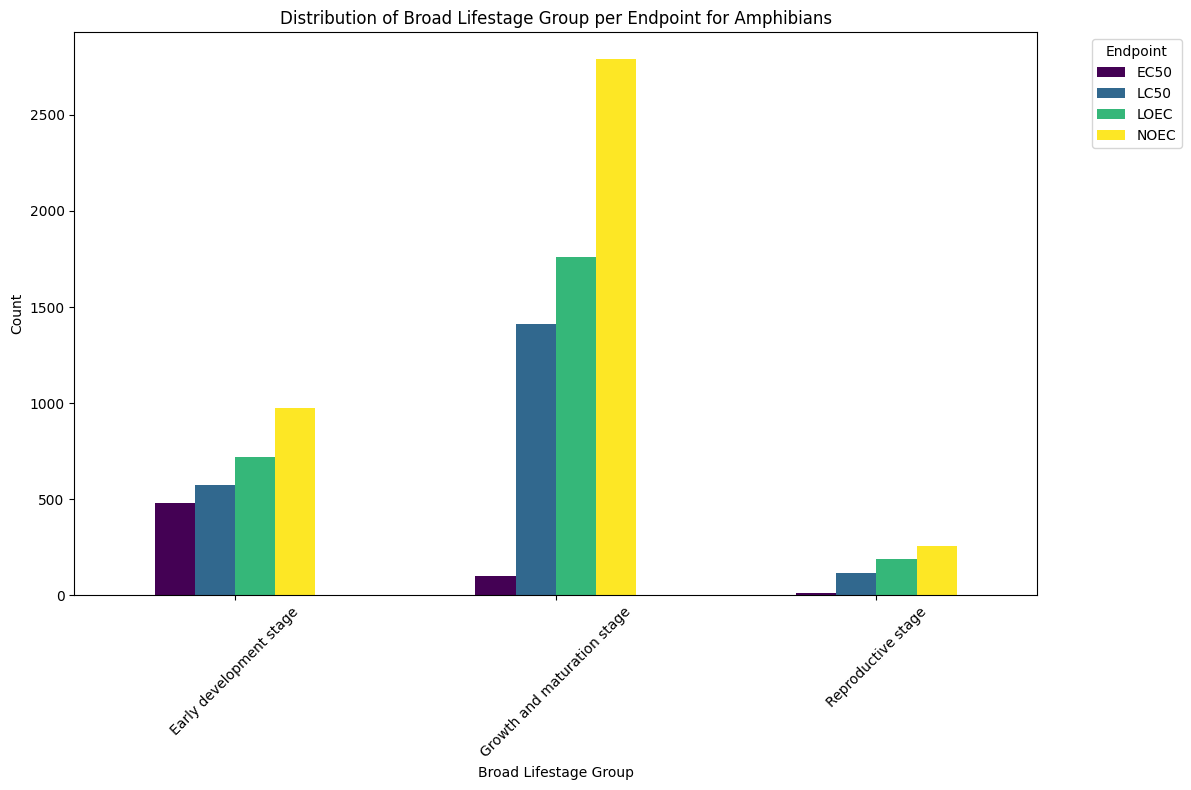

Data Distribution for Amphibians:
Endpoint                     EC50  LC50  LOEC  NOEC
Broad Lifestage Group                              
Early development stage       481   576   722   973
Growth and maturation stage   101  1411  1762  2790
Reproductive stage             14   116   188   257 



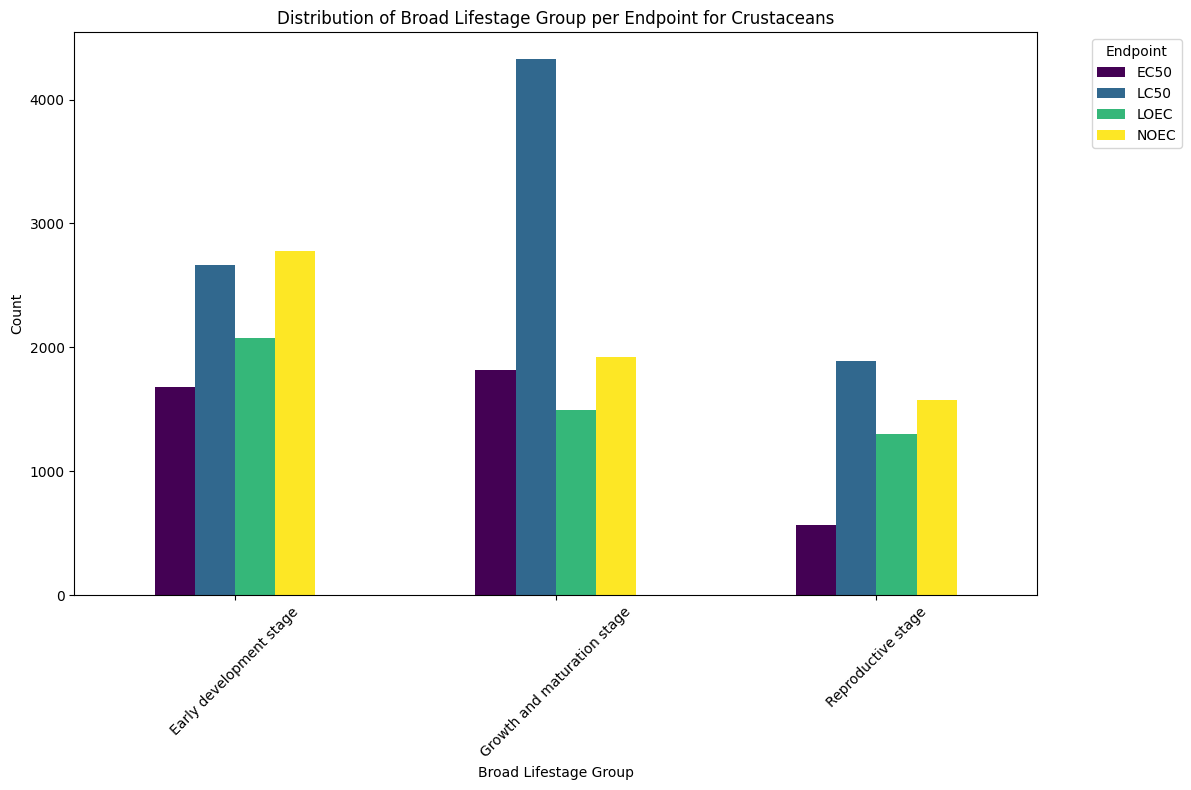

Data Distribution for Crustaceans:
Endpoint                     EC50  LC50  LOEC  NOEC
Broad Lifestage Group                              
Early development stage      1677  2665  2073  2776
Growth and maturation stage  1818  4326  1495  1920
Reproductive stage            569  1892  1301  1578 



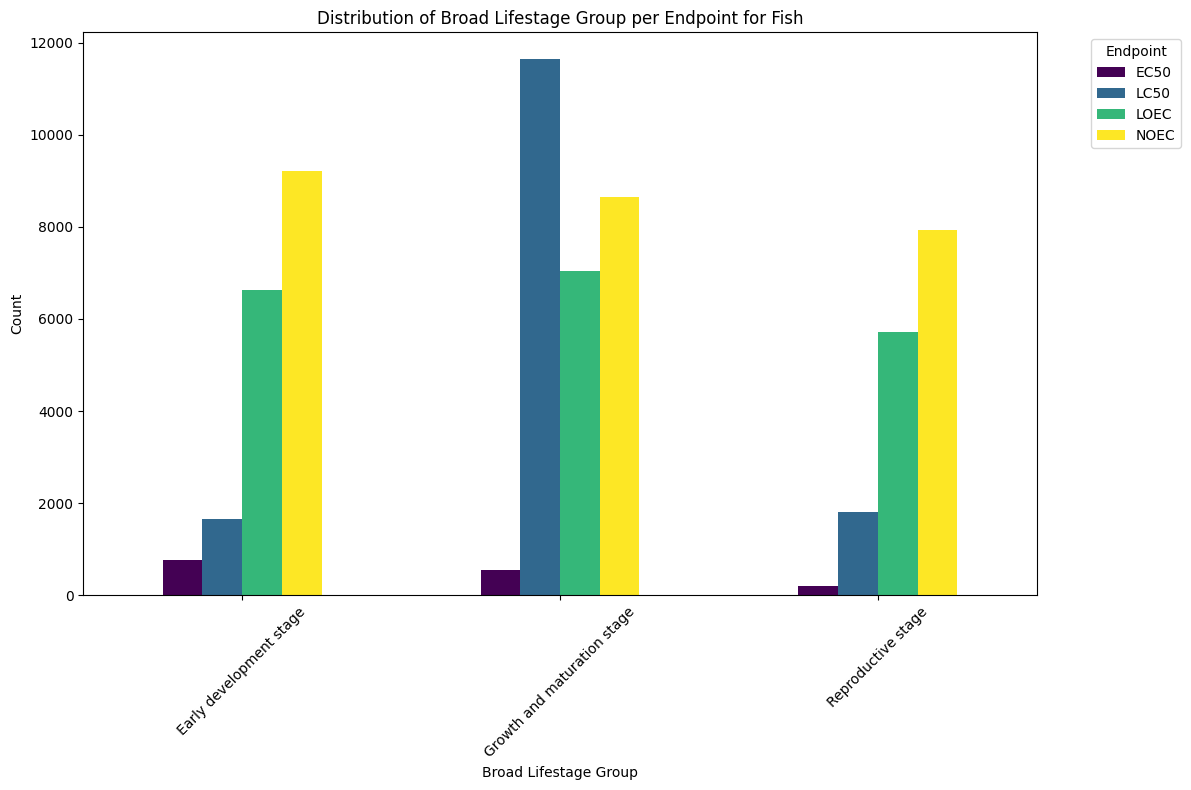

Data Distribution for Fish:
Endpoint                     EC50   LC50  LOEC  NOEC
Broad Lifestage Group                               
Early development stage       763   1660  6627  9204
Growth and maturation stage   542  11641  7045  8644
Reproductive stage            194   1813  5710  7939 



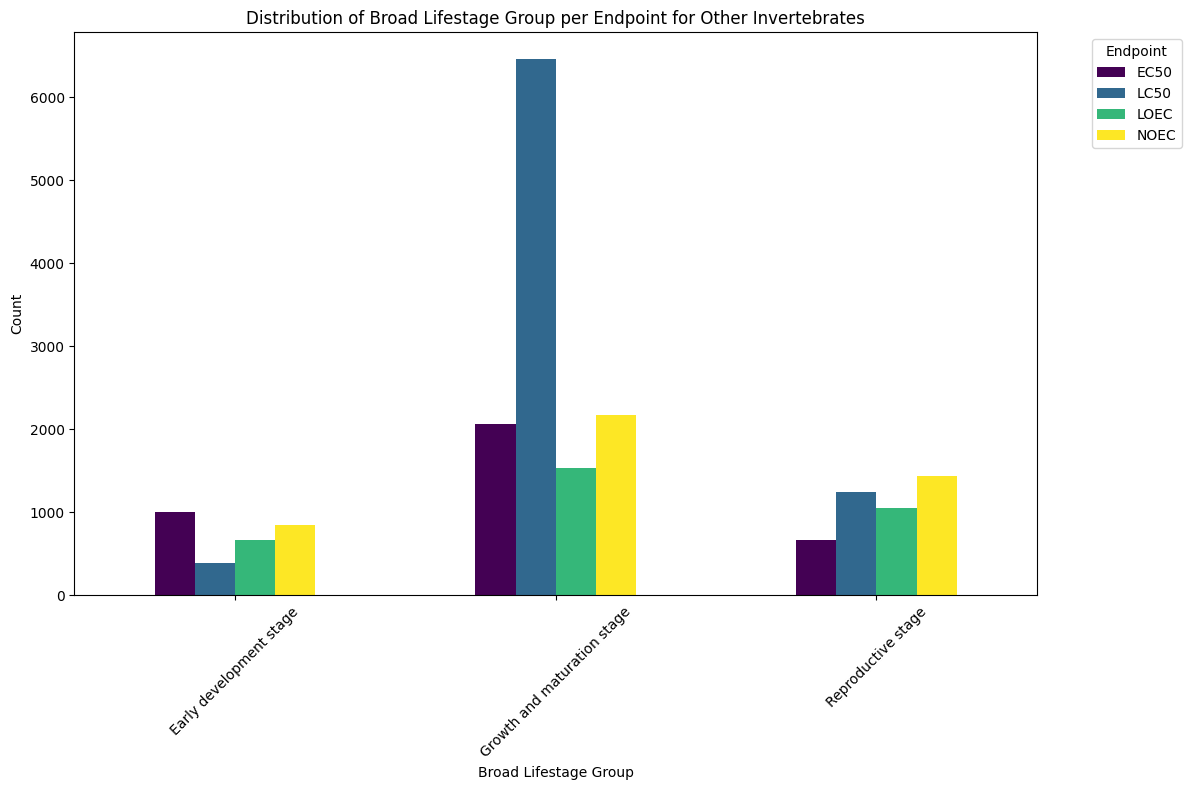

Data Distribution for Other Invertebrates:
Endpoint                     EC50  LC50  LOEC  NOEC
Broad Lifestage Group                              
Early development stage       999   389   667   850
Growth and maturation stage  2066  6456  1539  2172
Reproductive stage            662  1250  1049  1431 



In [ ]:
curated_df = df_with_smiles_and_inchikey[~df_with_smiles_and_inchikey['Curated_SMILES'].isnull()]

# Get unique species from the 'Species Group' column
species_groups = curated_df['Species Group'].unique()

# Create an empty dictionary to store DataFrame for each species
species_pivot_tables = {}

for species in species_groups:
    # Filter DataFrame for the current species
    df_species = curated_df[curated_df['Species Group'] == species]

    # Group by 'Endpoint' and 'Broad Lifestage Group' and count the occurrences
    endpoint_lifestage_counts = df_species.groupby(['Endpoint', 'Broad Lifestage Group']).size()

    # Reset the index to turn the results into a DataFrame
    endpoint_lifestage_counts_df = endpoint_lifestage_counts.reset_index(name='Count')

    # Pivot the DataFrame to get 'Broad Lifestage Group' as rows, 'Endpoint' as columns, and 'Count' as cell values
    pivoted_df = endpoint_lifestage_counts_df.pivot(index='Broad Lifestage Group', columns='Endpoint', values='Count').fillna(0)

    if len(pivoted_df) > 0:
        # Store the pivoted DataFrame in the dictionary using the species name as the key
        species_pivot_tables[species] = pivoted_df

        # Plotting the data for the current species
        pivoted_df.plot(kind='bar', stacked=False, figsize=(12, 8), colormap='viridis')

        # Customizing the plot
        plt.title(f'Distribution of Broad Lifestage Group per Endpoint for {species}')
        plt.xlabel('Broad Lifestage Group')
        plt.ylabel('Count')
        plt.xticks(rotation=45)  # Rotate labels to improve readability
        plt.legend(title='Endpoint', bbox_to_anchor=(1.05, 1), loc='upper left')

        # Show and save the plot
        plt.tight_layout()
        plt.savefig(f'Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/Figures/LifeStageData_curated_distribution_{species}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Optionally print the pivoted DataFrame
        print(f"Data Distribution for {species}:")
        print(pivoted_df, "\n")
        pivoted_df.to_csv(f'Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/Stats/LifeStageData_curated_distribution_{species}.csv')

In [ ]:
curated_df.to_csv("Analysis&Modeling/Integrated Analysis/1.Life_Stage_Analysis/DataSet/5.LifeStageData-CompoundsCurated.csv", index=False)